# Fungsi Dasar

In [12]:
import re, unicodedata 

# === helpers ===
ZW_RE = re.compile(r"[\u200b-\u200d\u2060\ufeff\u00ad\u200e\u200f]")
NBSP_RE = re.compile(r"[\u00A0]")
MULTI_SPACE_RE = re.compile(r"\s{2,}")

# wiki image markup (case-insensitive)
WIKI_IMG_TOKEN_RE = re.compile(
    r"(?i)(?:\|\s*(?:jmpl|thumb|kiri|kanan|ka)\b|\b(?:jmpl|thumb|kiri|kanan|ka)\b\s*\|?)"
)
WIKI_IMG_SIZE_RE = re.compile(
    r"(?i)(?:\|\s*\d{2,4}(?:x\d{2,4})?px\b|\b\d{2,4}(?:x\d{2,4})?px\b\s*\|?)"
)
# sisa pipa/whitespace berlebih
PIPE_SPACES_RE = re.compile(r"(?:\s*\|\s*)+")

_UNITS = r"(km2|m2|km|m|cm|mm|kg|g|mg|t|l|ml|hz|khz|mhz|ghz|v|kv|w|kw|mw|a|ma|pa|kpa|mpa|bar|%)"

def normalize(q: str, lowercase: bool = True) -> str:
    if not q:
        return ""
    # -------- hapus sitasi [angka] --------
    q = re.sub(r"\[\d+\]", "", q)

    # -------- unicode & basic cleanup --------
    q = unicodedata.normalize("NFKC", q)
    q = ZW_RE.sub("", q)
    q = NBSP_RE.sub(" ", q)

    # -------- bersihkan artefak gambar wiki --------
    for _ in range(2):
        q = WIKI_IMG_TOKEN_RE.sub(" ", q)
        q = WIKI_IMG_SIZE_RE.sub(" ", q)
    q = PIPE_SPACES_RE.sub(" ", q)

    # -------- bersihkan artefak HTML/parsoid --------
    q = q.replace(r"\'", "'").replace(r'\"', '"')
    # A) buang tag italic <i ...> / </i> lengkap/terpenggal
    q = re.sub(r"(?i)(?<=\w)<\s*/?\s*i\b[^>]*>?(?=\w)", "", q)
    q = re.sub(r"(?i)<\s*/?\s*i\b[^>]*>?", " ", q)
    q = re.sub(r"(?i)<\s*/?\s*i\b[^\n<]*$", " ", q)

    # 1) hapus atribut data-parsoid (toleran kutip/penutup tidak lengkap)
    q = re.sub(
        r"\s*data-parsoid\s*=\s*(?:'[^']*'?|\"[^\"]*\"?|[^>\s]+)"," ",q,flags=re.IGNORECASE,
    )

    # C) HAPUS "dsr":[<deret angka/titik>] MESKI TANPA PENUTUP
    #    Contoh yang disapu: "dsr":[417424.3.3   atau   'dsr':[12.34
    q = re.sub(r'''(?i)["']dsr["']\s*:\s*\[\s*[0-9.,-]*''', " ", q)
    #    Tambahan: kalau key-nya (korup) tanpa kutip
    q = re.sub(r'''(?i)\bdsr\b\s*:\s*\[\s*[0-9.,-]*''', " ", q)

    # D) setelah dsr dihapus sering tersisa buntut seperti "}'>", buang:
    q = re.sub(r"\}\s*['\"]?\s*>", " ", q)          # }'>  atau }">  → spasi
    q = re.sub(r"(?<=\S)['\"]\s*>", " ", q)         # '>, "> setelah token lain → spasi
    # D) buang penutup yang menggantung (], }, ) + opsional ' atau " atau >) tepat sebelum huruf
    q = re.sub(r'(?:(?<=^)|(?<=\s))[\]\}\)]+(?:\s*["\']?\s*>?)?\s*(?=\w)', '', q)


    # 1) Hapus tag yang berada DI DALAM kata tanpa meninggalkan spasi
    q = re.sub(r"(?<=\w)</?\s*[a-zA-Z][^>]*>(?=\w)", "", q)

    # hapus tag HTML normal (misalnya <b>...</b>)
    q = re.sub(r"</?\s*[a-zA-Z][^>]*>", " ", q)

    # sambungkan huruf yang terpisah oleh tag patah /b>, /i>, /u>, /s>
    q = re.sub(r"(?<=\w)/[bius]>(?=\w)", "", q, flags=re.IGNORECASE)

    # hilangkan sisa /b> /i> /u> /s> sendirian
    q = re.sub(r"/[bius]>", " ", q, flags=re.IGNORECASE)

    # -------- lower & normalisasi tanda baca --------

    q = q.strip()
    q = (q.replace("“", "\"").replace("”", "\"")
           .replace("‘", "'").replace("’", "'")
           .replace("…", "...")
           .replace("–", "-").replace("—", "-")
           .replace("؟", "?").replace("．", ".").replace("؟", "?"))
    
    if lowercase:
        q = q.lower()

    # --- spasi + tanda baca (ramah tanda kurung) ---
    q = re.sub(r"\s+\?", "?", q)                            # hapus spasi sebelum '?'
    q = re.sub(r"\s+([,.:;!?/\)\-])", r"\1", q)             # hapus spasi sebelum tanda baca (kecuali '(')
    q = re.sub(r"([/(])\s+", r"\1", q)                      # hapus spasi setelah '/' dan '('
    q = re.sub(r"(?<=\w)\(", r" (", q)                      # pastikan ada spasi sebelum '(' bila didahului huruf/angka
    q = re.sub(r"\)(?=\w)", r") ", q)                       # pastikan ada spasi setelah ')' bila diikuti huruf/angka

    # rapikan spasi
    q = MULTI_SPACE_RE.sub(" ", q).strip()

    # normalisasi ringan kosakata/angka
    q = re.sub(r"\bdi\s+mana\b", "dimana", q)
    q = re.sub(r"\byg\b", "yang", q)
    q = q.replace("km²", "km2").replace("m²", "m2")
    # --- sisipkan spasi antara angka dan satuan ---

    # 12km -> 12 km, 5m2 -> 5 m2, 100% -> 100 %
    q = re.sub(rf"(?i)(\d)\s*({_UNITS})\b", r"\1 \2", q)

    # suhu: 50°C / 50 °C -> 50 °C  (pastikan ada spasi sebelum '°' dan antara ° dengan huruf)
    q = re.sub(r"(?i)(\d)\s*°\s*([cf])\b", r"\1 °\2", q)

    q = re.sub(r"\s*&\s*", " dan ", q)
    q = re.sub(r"\?{2,}", "?", q)

    # final cleanup
    q = MULTI_SPACE_RE.sub(" ", q).strip()
    return q

In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def add_norm_and_stem(batch, column):
    qs = batch[column]
    norm = [normalize(x) for x in qs]
    stem = [stemmer.stem(x) for x in norm]  # stem setelah normalisasi
    return {f"{column}_norm": norm, f"{column}_stem": stem}

# Membuat Korpus Panjang 180 Token nan Sudah Dinormalisasi

Gunanya untuk 
1) Pretraining model xRAG
2) Menyusun data negative passages dari bagian dataset yang belum punya

In [11]:
from datasets import load_dataset
from transformers import AutoTokenizer
import re

# Load corpus & tokenizer
corpus = load_dataset("castorini/mr-tydi-corpus", "indonesian", trust_remote_code=True)
corpus

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'text'],
        num_rows: 1469399
    })
})

## EDA

nengok kasus dimana terdapat tag html atau yang mirip

In [ ]:
import re
import pandas as pd
from datasets import load_dataset

# Muat dataset (ganti sesuai punyamu)
ds = load_dataset("castorini/mr-tydi-corpus", "indonesian", split="train")

# Pola rawan
PATTERNS = {
    "slash_bius": re.compile(r"/[bius]>"),            # /b> /i> /u> /s>
    "broken_join": re.compile(r"\w/[bius]>\w"),       # d/b>e
    "data_parsoid": re.compile(r"data-parsoid\s*=", re.I),
    "dsr": re.compile(r'"dsr"\s*:\s*\[', re.I),
    "html_tag": re.compile(r"</?\s*[a-zA-Z][^>]*>"),  # <...> tag
}

# Simpan hasil match
records = []
for ex in ds.select(range(100000)):
    text = ex["text"]
    matches = {name: bool(pat.search(text)) for name, pat in PATTERNS.items()}
    if any(matches.values()):
        record = {
            "docid": ex["docid"],
            "title": ex["title"],
            "text_snippet": text,  # simpan potongan teks saja biar file tidak terlalu berat
        }
        record.update(matches)
        records.append(record)

# Buat DataFrame
df = pd.DataFrame(records)

# Simpan ke Excel
output_file = "mr_tydi_matches.xlsx"
df.to_excel(output_file, index=False)

print(f"Hasil disimpan ke {output_file}, total baris: {len(df)}")

Hasil disimpan ke mr_tydi_matches.xlsx, total baris: 97


## Normalisasi dan Chunking 180 Token

In [ ]:
from transformers import AutoTokenizer
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

MAX_TOK = 180
MIN_TOK = 50

# ---------- Normalisasi ----------

def normalize_batch(batch):
    batch["title"] = [normalize(t, lowercase=False) for t in batch["title"]]
    batch["text"] = [normalize(t, lowercase=False) for t in batch["text"]]
    return batch

# ---------- Chunking ----------
def chunk_batch(batch):
    out_docid, out_title, out_text = [], [], []
    for docid, title, text in zip(batch["docid"], batch["title"], batch["text"]):
        token_ids = t5_tokenizer.encode(text, add_special_tokens=False)
        if not token_ids:
            continue

        chunks = []
        start = 0
        while start < len(token_ids):
            end = min(start + MAX_TOK, len(token_ids))

            # pastikan akhir chunk di batas kata
            if end < len(token_ids):
                tok_str = t5_tokenizer.convert_ids_to_tokens([token_ids[end]])[0]
                while end > start and not tok_str.startswith("▁"):
                    end -= 1
                    tok_str = t5_tokenizer.convert_ids_to_tokens([token_ids[end]])[0]
                if end == start:
                    end = min(start + MAX_TOK, len(token_ids))

            chunks.append(token_ids[start:end])
            start = end

        # gabungkan segmen terakhir kalau <50 token
        if len(chunks) >= 2 and len(chunks[-1]) < MIN_TOK:
            chunks[-2].extend(chunks[-1])
            chunks = chunks[:-1]
        elif len(chunks) == 1 and len(chunks[0]) < MIN_TOK:
            chunks = []  # terlalu pendek → buang

        # simpan segmen valid
        for idx, seg in enumerate(chunks):
            if len(seg) < MIN_TOK:
                continue
            out_docid.append(f"{docid}_{idx}")
            out_title.append(title)
            out_text.append(t5_tokenizer.decode(seg, skip_special_tokens=True))

    return {"docid": out_docid, "title": out_title, "text": out_text}

# ---------- Pipeline ----------
# 1. Normalisasi dulu
normalized_corpus = corpus.map(
    normalize_batch,
    batched=True,
    desc="Normalizing title & text"
)

# 2. Chunking setelah normalisasi
split_dataset = normalized_corpus["train"].map(
    chunk_batch,
    batched=True,
    remove_columns=normalized_corpus["train"].column_names,
    desc="Chunking into <=180 tokens (word-aware) & merging last <50"
)

print(split_dataset)
print(split_dataset[0])

## Hapus Duplikasi

In [26]:
import pandas as pd

# ambil 10.000 baris pertama
sample = split_dataset.select(range(10000))

# konversi ke DataFrame untuk analisis cepat
df = pd.DataFrame(sample)

# cek duplikasi berdasarkan kolom 'text'
dup_mask = df.duplicated(subset=["text"], keep=False)
duplicates = df[dup_mask].sort_values(by="text")

# simpan hasil duplikat ke Excel
duplicates.to_excel("duplicates_first_10k.xlsx", index=False)

print(f"Jumlah duplikat (berdasarkan kolom text): {duplicates.shape[0]}")

Jumlah duplikat (berdasarkan kolom text): 38


In [28]:
import pandas as pd
from datasets import Dataset

# Konversi dulu ke pandas DataFrame
df = split_dataset.to_pandas()

# Hapus duplikasi berdasarkan kolom "text"
# keep='first' artinya baris pertama dipertahankan
df_nodup = df.drop_duplicates(subset=["text"], keep="first").reset_index(drop=True)

# Konversi kembali ke HuggingFace Dataset
split_dataset_nodup = Dataset.from_pandas(df_nodup)

print(f"Jumlah awal: {len(split_dataset)}, jumlah setelah buang duplikat: {len(split_dataset_nodup)}")


Jumlah awal: 1588236, jumlah setelah buang duplikat: 1521373


## Push ke Huggingface (Tanpa Pembagian Split)

In [29]:
# pip install datasets huggingface_hub

from datasets import DatasetDict
from huggingface_hub import HfApi, HfFolder
from datetime import datetime

# ====== asumsikan split_dataset sudah ada dari langkahmu sebelumnya ======
# split_dataset = normalized_corpus["train"].map(...)

# Bungkus ke DatasetDict agar rapi (boleh tambah 'validation'/'test' kalau ada)
split_dataset_dict = DatasetDict({"train": split_dataset})

# ====== Konfigurasi repo ======
repo_id = "khalidrizki/indonesian-wiki-chunked-180tok"   # ganti
private = False                                          # True kalau mau privat
token = HfFolder.get_token()
api = HfApi()

# 1) Buat repo (jika belum ada)
api.create_repo(
    repo_id=repo_id,
    repo_type="dataset",
    private=private,
    exist_ok=True,
    token=token,
)

# 2) Push dataset
split_dataset_dict.push_to_hub(
    repo_id=repo_id,
    private=private,
)

# 3) Siapkan README (dataset card)
readme = f"""# mr-tydi-indonesian-chunked-180tok

Hasil preprocessing dari [`castorini/mr-tydi-corpus`](https://huggingface.co/datasets/castorini/mr-tydi-corpus) split **Indonesian**.

## Pipeline
1. **Normalisasi teks**
   - Bersihkan artefak Parsoid/markup wiki (mis. `data-parsoid`, `dsr`, tag HTML patah)
   - Normalisasi whitespace & tanda baca
2. **Chunking word-aware**
   - Tokenizer: **google/flan-t5-base** (SentencePiece)
   - Panjang segmen ≤ **180 token**
   - Pemotongan berhenti di **batas kata** (hindari potong subword di tengah)
   - Jika segmen terakhir < **50 token**, **digabung** ke segmen sebelumnya
3. **docid baru**
   - Format: `docidAsli#partisiOlehMrTydi_nomorSegmen` (mis. `12345#67_0`, `12345#67_1`, …)

## Statistik
- Dataset asli (train, ID): ≈ 1.47M dokumen
- Dataset hasil chunking: lebih besar (tergantung distribusi panjang)
- Panjang segmen: 50–180 token (bisa >180 bila segmen terakhir digabung)

## Contoh
```json
{{
  "docid": "12345#0_0",
  "title": "Dokar",
  "text": "Dokar, kendaraan dengan kuda sebagai penarik ..."
}}"""

Creating parquet from Arrow format: 100%|██████████| 795/795 [00:02<00:00, 283.55ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Creating parquet from Arrow format: 100%|██████████| 795/795 [00:02<00:00, 315.18ba/s]
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Uploading the dataset shards: 100%|██████████| 2/2 [00:52<00:00, 26.10s/it]


## 180 Token Menurut Flan T5 itu Berapa Token Multilingual E5?

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np

# 1. Load dataset & tokenizer
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok", split="train")
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-base")

# 2. Ambil sampel 100.000 data secara acak
sampled = corpus.shuffle(seed=42).select(range(100_000))

# 3. Tokenisasi batch agar lebih cepat
def tokenize_batch(batch):
    tokens = tokenizer(batch["text"], truncation=False, padding=False)["input_ids"]
    return {"lengths": [len(t) for t in tokens]}

sampled = sampled.map(tokenize_batch, batched=True, batch_size=1000)

# 4. Hitung rata-rata panjang token
avg_length = np.mean(sampled["lengths"])
print(f"Rata-rata panjang token dari 100.000 sampel: {avg_length:.2f}")

Map: 100%|██████████| 100000/100000 [00:08<00:00, 11193.50 examples/s]

Rata-rata panjang token dari 100.000 sampel: 65.77


## Pembagian Split (Train dan Validasi)

In [ ]:
from datasets import load_dataset
import random
import numpy as np

# Load dataset
dataset = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok", split="train")

# Ekstrak prefix sebelum '#'
def get_doc_prefix(example):
    return {"doc_prefix": example["docid"].split("#")[0]}

dataset = dataset.map(get_doc_prefix)

# Group dokumen unik
all_docs = list(set(dataset["doc_prefix"]))
random.seed(42)
random.shuffle(all_docs)

# Hitung target size
target_val_size = 7941

# Iteratif pilih dokumen sampai mendekati target
val_docs = []
val_count = 0
for d in all_docs:
    count_d = (np.array(dataset["doc_prefix"]) == d).sum()
    if val_count + count_d <= target_val_size:
        val_docs.append(d)
        val_count += count_d
    if val_count >= target_val_size:
        break

print(f"Validation rows: {val_count}, Target: {target_val_size}")

# Split dataset
val_dataset = dataset.filter(lambda x: x["doc_prefix"] in val_docs)
train_dataset = dataset.filter(lambda x: x["doc_prefix"] not in val_docs)

print(train_dataset)
print(val_dataset)

Validation rows: 7941, Target: 7941


Filter: 100%|██████████| 1588236/1588236 [01:11<00:00, 22218.61 examples/s]

Dataset({
    features: ['docid', 'title', 'text', 'doc_prefix'],
    num_rows: 1580295
})
Dataset({
    features: ['docid', 'title', 'text', 'doc_prefix'],
    num_rows: 7941
})


In [ ]:
from datasets import DatasetDict

# Gabungkan ke dalam DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "dev": val_dataset
})

dataset.push_to_hub("khalidrizki/indonesian-wiki-chunked-180tok-splitted")

# TyDi QA

## Khusus Data Question dan Answer (Tanpa Retrieval/Negative Passages)

Gabungkan semua split jadi 1

In [3]:
from datasets import load_dataset, concatenate_datasets

# Muat dataset
tydiqa_gold = load_dataset("khalidalt/tydiqa-goldp", "indonesian", trust_remote_code=True)

# Gabungkan semua split di tydiqa_gold
tydiqa_gold_all = concatenate_datasets([tydiqa_gold[split] for split in tydiqa_gold.keys()])

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tydiqa_gold_all

Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question_text', 'answers'],
    num_rows: 6267
})

Rename kolom question pada tydiqa menjadi query

In [4]:
tydiqa_gold_all = tydiqa_gold_all.rename_column("question_text", "question")

Normalisasi dan buat kolom question_stem, yakni query yang sudah di-stemming. Ini gunanya untuk memudahkan membuang duplikasi

In [5]:
tydiqa_gold_all = tydiqa_gold_all.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
tydiqa_gold_all

Map: 100%|██████████| 6267/6267 [09:34<00:00, 10.91 examples/s]


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 6267
})

Dengan melakukan inspeksi manual, dari baris yang question_stem nya terduplikasi, sudah ditentukan mana saja baris yang answer nya salah. 

Dengan demikian, baris-baris yang question_stem terduplikasi dan answer salah tersebut dihapus

In [6]:
# ====== 2) Daftar pasangan dari Excel (sudah dituliskan ulang ke kode) ======
EXCEL_PAIRS = [
    ("apa bilang ganjil", "t dibuktikan bahwa bilangan ganjil"),
    ('apa definisi dari budaya', 'cara hidup yang berkembang, dan dimiliki bersama oleh sebuah kelompok orang, dan diwariskan dari generasi ke generasi'),
    ('apa erti pasar dalam ilmu ekonomi', 'empat bertemunya penjual dan pembeli. Transaksi jual-beli yang terjadi tidak selalu memerlukan lokasi fisik'),
    ('apa ibukota israel', 'Yerusalem'),
    ('apa ibukota jerman', 'Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'),
    ('apa itu dna', '"dsr":[417,424,3,3]}\'>n</b>ucleic a</b>cid), adalah sejenis biomolekul yang menyimpan dan menyandi instruksi-instru'),
    ('apa itu manga', 'komik yang dibuat di Jepang, kata tersebut digunakan khusus untuk membicarakan tentang komik Jepang, sesuai dengan gaya yang dikembangkan di Jepang pada akhir abad ke-19'),
    ('apa itu rna', 'molekul polimer yang terlibat dalam berbagai peran biologis dalam mengkode, dekode, regulasi, dan ekspresi gen'),
    ('apa mata uang israel', 'Shekel baru Israel'),
    ('apa nama ibukota israel', 'Yerusalem'),
    ('apa nama ibukota jerman', 'Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'),
    ('apa nama mata uang israel', 'Shekel baru Israel'),
    ('apa warna bendera jepang', '6.2R 4/15.2 untuk merah dan N9.2 untuk putih'),
    ('apa yang maksud dengan budaya', 'suatu cara hidup yang berkembang, dan dimiliki bersama oleh sebuah kelompok orang, dan diwariskan dari generasi ke generasi'),
    ('apa yang maksud dengan monarki', 'merupakan sejenis pemerintahan yang dipimpin oleh seorang penguasa monarki'),
    ('apa yang maksud dengan surah makkiyah', 'yat-ayat yang turun sebelum Rasulullah SAW hijrah ke Madinah'),
    ('apa yang maksud dengan zaman meiji', 'salah satu nama zaman pemerintahan kaisar Jepang sewaktu Kaisar Meiji memerintah Jepang, sesudah tahun Keiō(慶応) dan sebelum zaman zaman Taishō(大正'),
    ('berapa luas danau toba', '100 kilometres (62 miles), lebar 30 kilometres (19mi), dan kedalaman 505 metres'),
    ('berapa luas jakarta timur', '187,75km² (menurut Pemerintah Kota Administrasi Jakarta Timur)[1], atau seluas 188,19km² (menurut Badan Perencanaan Pembangunan Daerah Khusus Ibu Kota Jakarta)'),
    ('berapa luas jerman', '357,021km'),
    ('berapa luas kolombia', "828,660km² dan yang kedua yang terbentuk oleh pegunungan Andes dan lempeng Llanos yang berbagi bersama Venezuela dengan area seluas 1'143,748km²"), 
    ('berapa luas kota lampung', '35.376,50km²'),
    ('berapa luas kuasa sultan mataram', 'Jawa dan sekitarnya, termasuk Madura'),
    ('berapa luas negara israel',	'27.799km2'),
    ("berapa luas papua","808.105km persegi"),
    ('berapa luas pulau jawa','160 juta'),
    ('berapa luas singapura', '5,815km'),
    ('berapa luas sulawesi selatan','45.764,53'),
    ('berapa panjang sungai kuning'	,'40km'),
    ('dari mana asal suku sunda','bagian barat pulau Jawa, Indonesia'),
    ("kapan dinasti tang diri","618"),
    ("kapan internet pertama masuk ke indonesia","1994"),
    ("kapan perintah orde baru mulai","1966"),
    ("kapan pt kereta api indonesia diri","Mei 2010"),
    ("kapan pt kereta api indonesia diri","17 Juni 1864"),
    ("kapan radio pertama kali cipta","Guglielmo Marconi"),
    ("kapan universitas indonesia diri","1955"),
    ("mana letak jam gadang","kota Bukittinggi, Sumatera Barat, Indonesia"),
    ("mana letak jepang","ujung barat Samudra Pasifik, di sebelah timur Laut Jepang, dan bertetangga dengan Republik Rakyat Tiongkok, Korea, dan Rusia"),
    ("mana letak mesir","antara garis lintang 22 ° dan 32 ° N, dan garis bujur 25 ° dan 35 ° E"),
    ("mana letak polandia","Eropa Tengah yang berbatasan dengan Jerman di sebelah barat Perbatasan Oder-Neisse, Ceko, dan Slowakia di sebelah selatan, Rusia (Kaliningrad), Lituania di sebelah timur laut dan Belarus serta Ukraina di sebelah barat (Garis Curzon)"),
    ("siapa diri dinasti han timur","Liu Bang"),
    ("siapa diri toyota motor corporation","Toyoda"),
    ("siapa nama kaisar pertama dinasti ming","Zhu Yuanzhang"),
    ("siapa yang cipta wiracarita mahabharata","Begawan Byasa atau Vyasa"), 
    ("apa erti dari digital", "penggambaran dari suatu keadaan bilangan yang terdiri dari angka 0 dan 1 atau off dan on (bilangan biner)"),
    ("berapa luas jambi", "53.435 km2"),
    ("kapan sultan utsmaniyah diri", "bawa"),
    ("apa itu dvd", "cakram padat yang dapat digunakan untuk menyimpan data, termasuk film dengan kualitas video dan audio yang lebih baik dari kualitas VCD"),
    ("apa nama ibukota provinsi sulawesi utara", "kota Manado"), 
    ("apa nama mata uang korea utara", "Won"), 
    ("berapa luas samudera atlantik", "106.450.000km²"),
    ("mana letak danau toba", "kaldera Gunung Berapi Super")
]

# Ubah ke set untuk lookup cepat; trimming spasi di kiri/kanan biar "persis" tapi toleran spasi ekstra
PAIRS_SET = set((qs.strip(), ans.strip()) for qs, ans in EXCEL_PAIRS)

# ====== 3) Hapus baris di tydiqa_gold_all yang match kombinasi (question_stem, answers.text) ======
# Asumsi: kolom 'question_stem' SUDAH ada di tydiqa_gold_all
def _should_keep(example):
    qstem = (example.get('question_stem') or "").strip()
    texts = example.get('answers', {}).get('text', []) or []
    # hapus baris bila ADA salah satu jawaban yang match persis
    for t in texts:
        if (qstem, (t or "").strip()) in PAIRS_SET:
            return False
    return True

before_n = len(tydiqa_gold_all)
filtered_train = tydiqa_gold_all.filter(_should_keep)
after_n = len(filtered_train)
removed = before_n - after_n

print(f"Rows before: {before_n} | after: {after_n} | removed: {removed}")

# (Opsional) laporan pasangan Excel yang tidak ketemu sama sekali di dataset
# Kita cek apakah ada contoh yang match; kalau tidak ada, kita laporkan
def _has_match(example):
    qstem = (example.get('question_stem') or "").strip()
    texts = example.get('answers', {}).get('text', []) or []
    out = []
    for t in texts:
        key = (qstem, (t or "").strip())
        if key in PAIRS_SET:
            out.append(key)
    return {"_hits": out}

hits_ds = tydiqa_gold_all.map(_has_match, batched=False)
found_pairs = set()
for row in hits_ds:
    for h in row.get("_hits", []):
        found_pairs.add(tuple(h))

not_found = PAIRS_SET - found_pairs
if not_found:
    print("\nPairs from Excel NOT FOUND in dataset:")
    for qs, ans in sorted(not_found):
        print(f"- question_stem={qs!r} | answers.text={ans!r}")

# Commit hasil filter
tydiqa_gold_all_dupe_wo_bad_labels = filtered_train
tydiqa_gold_all_dupe_wo_bad_labels

Filter: 100%|██████████| 6267/6267 [00:00<00:00, 22557.43 examples/s]


Rows before: 6267 | after: 6219 | removed: 48


Map: 100%|██████████| 6267/6267 [00:01<00:00, 4946.92 examples/s]



Pairs from Excel NOT FOUND in dataset:
- question_stem='apa bilang ganjil' | answers.text='t dibuktikan bahwa bilangan ganjil'
- question_stem='apa ibukota israel' | answers.text='Yerusalem'
- question_stem='apa ibukota jerman' | answers.text='Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'
- question_stem='apa nama ibukota israel' | answers.text='Yerusalem'
- question_stem='apa nama ibukota jerman' | answers.text='Jerman Timur memilih Berlin Timur sebagai ibukota, sedangkan Jerman Barat memilih Bonn'
- question_stem='apa nama ibukota provinsi sulawesi utara' | answers.text='kota Manado'
- question_stem='apa nama mata uang korea utara' | answers.text='Won'
- question_stem='apa warna bendera jepang' | answers.text='6.2R 4/15.2 untuk merah dan N9.2 untuk putih'
- question_stem='apa yang maksud dengan surah makkiyah' | answers.text='yat-ayat yang turun sebelum Rasulullah SAW hijrah ke Madinah'


Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question', 'answers', 'question_norm', 'question_stem'],
    num_rows: 6219
})

Ekstrak jawaban dari yang awalnya berada pada answers.text menjadi answer saja

In [7]:
def extract_text(example):
    example["answer"] = example["answers"]["text"]  # Ambil hanya bagian text, start_byte dan limit_byte dibuang saja
    return example

tydiqa_gold_all_dupe_wo_bad_labels = tydiqa_gold_all_dupe_wo_bad_labels.map(extract_text)
tydiqa_gold_all_dupe_wo_bad_labels = tydiqa_gold_all_dupe_wo_bad_labels.remove_columns(["language", "answers"])

Map: 100%|██████████| 6219/6219 [00:01<00:00, 4696.50 examples/s]


In [8]:
def passage_miss_answer(example):
    passage = example["passage_text"]
    answers = example["answer"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 6219/6219 [00:00<00:00, 38414.74 examples/s]

Jumlah baris yang miss: 0


Inspect lagi, apakah untuk kelompok question_stem sama (terduplikasi), apakah ada passage_text yang passage_text nya berbeda satu sama lain. Kalau berbeda, cek apakah jawaban berbeda juga. Jika jawaban berbeda, cari baris yang jawabannya benar dan sesuai dengan passage_text. Jawaban yang salah kemudian dihapus. Pencarian jawaban salah dilakukan dengan manual.

In [ ]:
# import pandas as pd

# # pastikan kolom yang dibutuhkan ada
# required_cols = {"question_stem", "document_title", "passage_text"}
# missing = required_cols - set(tydiqa_gold_all_dupe_wo_bad_labels.column_names)
# assert not missing, f"Kolom hilang: {missing}"

# # ke pandas untuk analisis cepat
# df = tydiqa_gold_all_dupe_wo_bad_labels.to_pandas()

# # ambil hanya question_stem yang duplikat (>1 kemunculan)
# dup_keys = (
#     df.groupby("question_stem", dropna=False).size()
#       .reset_index(name="n")
#       .query("n > 1")["question_stem"]
# )

# dup_df = df[df["question_stem"].isin(dup_keys)].copy()

# # ringkasan per question_stem
# def _unique_list(s, k=3):
#     # ambil contoh unik maksimal k item untuk pratinjau
#     vals = pd.unique(s.dropna())
#     return list(vals[:k])

# summary = (
#     dup_df.groupby("question_stem", dropna=False)
#           .agg(
#               n_rows=("question_stem", "size"),
#               n_titles=("document_title", pd.Series.nunique),
#               n_passages=("passage_text", pd.Series.nunique),
#               titles_sample=("document_title", lambda s: _unique_list(s, k=3)),
#               passages_sample=("passage_text", lambda s: _unique_list(s, k=1)),
#           )
#           .reset_index()
# )

# summary["same_title"] = summary["n_titles"].eq(1)
# summary["same_passage"] = summary["n_passages"].eq(1)
# summary["all_same"] = summary["same_title"] & summary["same_passage"]

# # baris yang tidak konsisten (judul atau passage berbeda)
# conflicts = summary.query("~all_same").copy()

# print(f"Total question_stem duplikat: {len(summary)}")
# print(f"Grup konsisten (judul & passage sama semua): {summary['all_same'].sum()}")
# print(f"Grup konflik (judul/passage berbeda): {len(conflicts)}")

# # contoh menampilkan beberapa konflik
# if len(conflicts):
#     print("\n=== Contoh konflik (maks 5) ===")
#     for _, r in conflicts.head(5).iterrows():
#         print(f"- question_stem: {r['question_stem']!r} | n_rows={r['n_rows']}, "
#               f"n_titles={r['n_titles']}, n_passages={r['n_passages']}")
#         print(f"  titles_sample: {r['titles_sample']}")
#         print(f"  passages_sample: {r['passages_sample']}")
#         print("-"*60)

# # (Opsional) simpan hasil
# summary.to_excel("tydiqa_gold_dupe_groups_summary.xlsx", index=False)
# conflicts.to_excel("tydiqa_gold_dupe_groups_conflicts.xlsx", index=False)

Total question_stem duplikat: 224
Grup konsisten (judul & passage sama semua): 205
Grup konflik (judul/passage berbeda): 19

=== Contoh konflik (maks 5) ===
- question_stem: 'apa ibukota rusia' | n_rows=2, n_titles=1, n_passages=2
  titles_sample: ['Rusia']
  passages_sample: ['Sebagian besar jalur air Rusia sepanjang 102,000km (63,380mi) terdiri dari sungai atau danau alam. Ibukota Moskwa disebut sebagai "pelabuhan lima laut" karena memiliki 5 jalur air menuju Baltik, Laut Putih, Kaspia, Laut Azov dan Laut Hitam.']
------------------------------------------------------------
- question_stem: 'apa mata uang yang guna di jerman' | n_rows=2, n_titles=1, n_passages=2
  titles_sample: ['Mark Jerman']
  passages_sample: ['Peralihan dari mata uang resmi yang lama ke euro di Jerman berbeda dengan negara-negara Zona Euro lainnya. Di negara-negara lain, saat peralihan mata uang resmi lama dan euro beredar berdampingan selama dua bulan. Tetapi, di Jerman, koin dan uang kertas mark masih diterima

Penghapusan baris berdasarkan question_stem dan passage_text/answer yang salah. Baris berikut sudah diketahui query nya terduplikasi. Berhubung jawabannya pun salah, sekalian aja hapus dulu, biar nanti pas proses penghapusan query ga sengaja meninggalkan baris dengan answer yang salah

In [9]:
import numpy as np

# ====== daftar pasangan ======
Q_ANSWER_PAIRS = [
    ("apa yang maksud dengan uskup",
     "pimpinan Gereja setempat yang bernama Keuskupan dan merupakan bagian dari hierarki Gereja Katolik Roma setelah Sri Paus (Uskup Agung Roma) dan Kardinal"),
    ("berapa lama kaisar romawi kuasa", "27 SM sampai 284 M"),
    ("berapa luas korea selatan", "99.274km2"),
    ("berapa luas negara jepang", "377.835km²"),
]

Q_PSGTEXT_STARTSWITH_PAIRS = [
    ("kapan internet masuk ke indonesia pertama kali",
     "Sejarah internet Indonesia dimulai pada awal tahun 1990-an."),
    ("kapan komputer pertama kali cipta",
     "Sebelum Internet muncul, telah ada beberapa sistem komunikasi yang berbasis digital"),
]

# Lookup cepat
ANSWER_SET = set((q.strip(), a.strip()) for q, a in Q_ANSWER_PAIRS)
PFX_LIST  = [(q.strip(), pfx.strip()) for q, pfx in Q_PSGTEXT_STARTSWITH_PAIRS]

def _iter_answers(val):
    """Yield jawaban sebagai string-strip, terlepas val= str / list / tuple / np.ndarray / None."""
    if val is None:
        return
    if isinstance(val, (list, tuple, np.ndarray)):
        for x in val:
            if x is None:
                continue
            yield str(x).strip()
    else:
        yield str(val).strip()

def _should_drop(example):
    qstem = (example.get("question_stem") or "").strip()
    psg   = (example.get("passage_text") or "").strip()

    # Rule 1: (question_stem, answer) exact match
    for a in _iter_answers(example.get("answer")):
        if (qstem, a) in ANSWER_SET:
            return True

    # Rule 2: (question_stem, passage_text startswith prefix)
    for q, pfx in PFX_LIST:
        if qstem == q and psg.startswith(pfx):
            return True

    return False

# === Flag → filter ===
before_n = len(tydiqa_gold_all_dupe_wo_bad_labels)

flagged = tydiqa_gold_all_dupe_wo_bad_labels.map(
    lambda ex: {"_drop": _should_drop(ex)}, batched=False
)

removed_rows = flagged.filter(lambda ex: ex["_drop"])
kept         = flagged.filter(lambda ex: not ex["_drop"]).remove_columns(["_drop"])

after_n   = len(kept)
removed_n = before_n - after_n
print(f"Rows before: {before_n} | after: {after_n} | removed: {removed_n}")

# Commit hasil bersih kembali ke variabel asal (kalau diinginkan)
tydiqa_gold_all_dupe_wo_bad_labels = kept

# (Opsional) simpan audit baris yang dihapus
# removed_rows.to_csv("tydiqa_removed_rows.csv")


Filter: 100%|██████████| 6219/6219 [00:00<00:00, 35384.53 examples/s]


Rows before: 6219 | after: 6213 | removed: 6


In [10]:
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 6213/6213 [00:00<00:00, 18761.51 examples/s]

Jumlah baris yang miss: 0


Penghapusan duplikasi dengan menyisakan passage_text yang lebih pendek

In [11]:
import pandas as pd
from datasets import Dataset

# convert ke pandas
df = tydiqa_gold_all_dupe_wo_bad_labels.to_pandas()

# hitung panjang passage_text (kalau NaN → inf supaya tidak kepilih)
df["_passage_len"] = df["passage_text"].fillna("").str.len()

# untuk tiap question_stem, ambil index baris dengan passage_text terpendek
idx_min = df.groupby("question_stem")["_passage_len"].idxmin()

# ambil hanya baris-baris itu
df_kept = df.loc[idx_min].reset_index(drop=True)

print(f"Before: {len(df)} | After: {len(df_kept)} | Removed: {len(df) - len(df_kept)}")

# buang kolom bantu
df_kept = df_kept.drop(columns=["_passage_len"])

# convert balik ke HuggingFace Dataset
tydiqa_gold_all_dupe_wo_bad_labels = Dataset.from_pandas(df_kept)
tydiqa_gold_all_dupe_wo_bad_labels

Before: 6213 | After: 5971 | Removed: 242


Dataset({
    features: ['id', 'document_title', 'passage_text', 'question', 'question_norm', 'question_stem', 'answer'],
    num_rows: 5971
})

In [12]:
tydi_miss = tydiqa_gold_all_dupe_wo_bad_labels.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5971/5971 [00:00<00:00, 48639.03 examples/s]

Jumlah baris yang miss: 0


Isi text dari split dev dan test mr_tydi

In [13]:
corpus = load_dataset("castorini/mr-tydi-corpus", "indonesian", trust_remote_code=True)

In [14]:
mr_tydi = load_dataset("castorini/mr-tydi", "indonesian")

# Buat dictionary {docid: (title, text)} untuk pencarian cepat
corpus_dict = {row["docid"]: (row["title"], row["text"]) for row in corpus["train"]}

# Fungsi untuk melengkapi positive_passages dalam dataset mr_tydi
def fill_passage_info(example):
    for passage in example["positive_passages"]:
        docid = passage["docid"]
        if docid in corpus_dict:  # Cek apakah docid ada di corpus
            passage["title"], passage["text"] = corpus_dict[docid]
    
    return example

# Terapkan fungsi untuk melengkapi positive_passages di split 'dev' dan 'test'
mr_tydi["dev"] = mr_tydi["dev"].map(fill_passage_info)
mr_tydi["test"] = mr_tydi["test"].map(fill_passage_info)

# Cek hasilnya
print(mr_tydi["dev"][0])
print(mr_tydi["test"][0])

{'query_id': '3', 'query': 'Dimana James Hepburn meninggal?', 'positive_passages': [{'docid': '2386357#15', 'text': 'Dia dipenjarakan di Puri Dragsholm, 75 kilometer Kopenhagen. Dia ditahan dalam apa yang dikatakan sebagai kondisi yang mengerikan. Dia meninggal pada bulan April 1578.[8][10]', 'title': 'James Hepburn'}], 'negative_passages': []}
{'query_id': '6148', 'query': 'Siapakah yang menemuka benua Amerika ?', 'positive_passages': [{'docid': '6874#1', 'text': "Kolumbus bukanlah orang pertama yang tiba di Amerika, yang ia dapati sudah diduduki. Ia juga bukan orang Eropa pertama yang sampai ke benua itu karena sekarang telah diakui secara meluas bahwa orang-orang Viking dari Eropa Utara telah berkunjung ke Amerika Utara pada abad ke 11 dan mendirikan koloni L'Anse aux Meadows untuk jangka waktu singkat. Terdapat perkiraan bahwa pelayar yang tidak dikenali pernah melawat ke Amerika sebelum Kolumbus dan membekalkannya dengan sumber untuk kejayaannya. Terdapat juga banyak teori mengena

In [15]:
# Gabungkan semua split di mr_tydi
mr_tydi_all = concatenate_datasets([mr_tydi[split] for split in mr_tydi.keys()])

Normalisasi dan stemming query mr_tydi

In [16]:
mr_tydi_all = mr_tydi_all.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "query"}     
)

Map: 100%|██████████| 6955/6955 [01:09<00:00, 99.85 examples/s] 


Join kedua dataset

In [17]:
import numpy as np

# 1) Bangun index dari mr_tydi_all: query_norm -> list kandidat mr
mr_index = {}  # query_norm -> [ {query_id, positive_passages_raw, negative_passages_raw, positives_norm:[...]} ]
for qnorm, qid, pos_list, neg_list in zip(
    mr_tydi_all["query_norm"],
    mr_tydi_all["query_id"],
    mr_tydi_all["positive_passages"],
    mr_tydi_all["negative_passages"],
):
    rec = {
        "query_id": qid,
        "positive_passages_raw": pos_list or [],
        "negative_passages_raw": neg_list or [],
        "positives_norm": []
    }
    # siapkan versi ternormalisasi utk pencocokan cepat
    for p in (pos_list or []):
        title = (p.get("title") or "")
        text  = (p.get("text")  or "")
        rec["positives_norm"].append({
            "docid": p.get("docid"),
            "title": title,
            "title_norm": normalize(title),
            "text": text,
            "text_norm": normalize(text),
        })
    mr_index.setdefault(qnorm, []).append(rec)

# 2) Map ke tiap baris tydiqa: tambahkan kolom hasil join
def attach_mr_match(example):
    qnorm = example.get("question_norm") or ""
    cands = mr_index.get(qnorm, [])

    title_norm = normalize(example.get("document_title") or "")
    psg_norm   = normalize(example.get("passage_text")   or "")

    # default (tidak ketemu query_norm)
    if not cands:
        return {
            "mr_query_id": None,
            "mr_docid": None,
            "mr_title": None,
            "mr_text": None,
            "mr_negative_passages": [],   # <- kolom yang kamu minta ikut dibawa
            "mr_query_norm_match": False, # hanya query_norm?
            "mr_pos_match": False,        # apakah positive_passages (title+text) match?
        }

    # ada kandidat dengan query_norm sama
    # coba cari positive yang match (title & text)
    for cand in cands:
        for pos in cand["positives_norm"]:
            if pos["title_norm"] == title_norm and pos["text_norm"] == psg_norm:
                return {
                    "mr_query_id": cand["query_id"],
                    "mr_docid": pos["docid"],
                    "mr_title": pos["title"],
                    "mr_text": pos["text"],
                    "mr_negative_passages": cand["negative_passages_raw"],  # ikutkan apa adanya
                    "mr_query_norm_match": True,
                    "mr_pos_match": True,
                }

    # tidak ada positive yang match; tetap pilih kandidat pertama agar negative_passages tetap terisi
    cand0 = cands[0]
    return {
        "mr_query_id": cand0["query_id"],
        "mr_docid": None,
        "mr_title": None,
        "mr_text": None,
        "mr_negative_passages": cand0["negative_passages_raw"],
        "mr_query_norm_match": True,
        "mr_pos_match": False,
    }

# 3) Terapkan ke dataset tydiqa (tanpa menduplikasi baris)
tydiqa_with_mr = tydiqa_gold_all_dupe_wo_bad_labels.map(
    attach_mr_match,
    batched=False,
    load_from_cache_file=False,
)

# (opsional) ringkas hasil
total = len(tydiqa_with_mr)
qnorm_hits = sum(1 for b in tydiqa_with_mr["mr_query_norm_match"] if b)
pos_hits   = sum(1 for b in tydiqa_with_mr["mr_pos_match"] if b)
print(f"Query-norm matched: {qnorm_hits}/{total}")
print(f"Positive-passage fully matched (title+text): {pos_hits}/{total}")

# hasil akhirnya: tydiqa_with_mr punya kolom tambahan:
# ['mr_query_id','mr_docid','mr_title','mr_text','mr_negative_passages','mr_query_norm_match','mr_pos_match']


Map: 100%|██████████| 5971/5971 [00:05<00:00, 1063.87 examples/s]

Query-norm matched: 5955/5971
Positive-passage fully matched (title+text): 5580/5971


In [18]:
tydi_miss = tydiqa_with_mr.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5971/5971 [00:01<00:00, 3498.30 examples/s]

Jumlah baris yang miss: 0


Buang baris yang tidak nemu pasangan di mr_tydi_all

In [19]:
import pandas as pd

# 1) ambil orphan (tidak ada pasangan query_norm di mr_tydi_all)
orphans = tydiqa_with_mr.filter(lambda ex: not ex["mr_query_norm_match"])
print(f"Jumlah orphan: {len(orphans)}")

# # convert ke pandas biar bisa dicek/ekspor
# orphans_df = orphans.to_pandas()
# orphans_df.to_excel("tydiqa_orphans.xlsx", index=False)
# print("File tydiqa_orphans.xlsx berhasil dibuat.")

# 2) buang orphan dari dataset utama
tydiqa_with_mr = tydiqa_with_mr.filter(lambda ex: ex["mr_query_norm_match"])
print(f"Sekarang tydiqa_with_mr berisi {len(tydiqa_with_mr)} baris (orphan sudah dihapus).")

Filter: 100%|██████████| 5971/5971 [00:01<00:00, 3504.08 examples/s]


Jumlah orphan: 16


Filter: 100%|██████████| 5971/5971 [00:01<00:00, 3411.75 examples/s]

Sekarang tydiqa_with_mr berisi 5955 baris (orphan sudah dihapus).


Inspeksi lebih dalam terkait teks passage

In [ ]:
import re
import pandas as pd
from datasets import Dataset

# pola 'jmpl|' toleran spasi & case-insensitive
JMPL_RE = re.compile(r"jmpl\s*\|", flags=re.IGNORECASE)

# 1) ambil baris yang mengandung 'jmpl|'
def has_jmpl(example):
    txt = example.get("passage_text") or ""
    return bool(JMPL_RE.search(txt))

jmpl_ds = tydiqa_with_mr.filter(has_jmpl)
print(f"Baris yang mengandung 'jmpl|': {len(jmpl_ds)}")

# 2) tampilkan sampai 5 contoh (ke layar)
n_show = min(5, len(jmpl_ds))
if n_show > 0:
    print("\n=== Contoh passage dengan 'jmpl|' (maks 5) ===")
    for r in jmpl_ds.select(range(n_show)):
        print(f"id: {r.get('id')}")
        print(f"question_stem: {r.get('question_stem')}")
        print(f"document_title: {r.get('document_title')}")
        # tampilkan potongan teks agar mudah dibaca
        psg = (r.get('passage_text') or "").replace("\n", " ")
        print("passage_text (snippet):", psg[:400], "...")
        print("-" * 80)
else:
    print("Tidak ada 'jmpl|' yang ditemukan. Ambil 5 sampel acak untuk inspeksi manual.")
    n_show = min(5, len(tydiqa_with_mr))
    for r in tydiqa_with_mr.shuffle(seed=42).select(range(n_show)):
        print(f"id: {r.get('id')}")
        print(f"question_stem: {r.get('question_stem')}")
        print(f"document_title: {r.get('document_title')}")
        psg = (r.get('passage_text') or "").replace("\n", " ")
        print("passage_text (snippet):", psg[:400], "...")
        print("-" * 80)

# 3) simpan ke Excel untuk inspeksi lebih nyaman
#    - jika ada 'jmpl|', simpan contoh baris tersebut (maks 200 baris agar ringan)
#    - kalau tidak ada, simpan 200 sampel acak
if len(jmpl_ds) > 0:
    out_df = jmpl_ds.select(range(min(200, len(jmpl_ds)))).to_pandas()
    out_path = "tydiqa_passages_with_jmpl.xlsx"
else:
    out_df = tydiqa_with_mr.shuffle(seed=42).select(range(min(200, len(tydiqa_with_mr)))).to_pandas()
    out_path = "tydiqa_passages_sample.xlsx"

out_df.to_excel(out_path, index=False)
print(f"Disimpan ke: {out_path}")


In [ ]:
"""
Sampai tahap ini, sudah dilakukan:
1. Penggabungan split TyDi QA
2. Normalisasi dan stemming question
3. Penghapusan duplikasi

4. Mengisi psg positif dari split dev dan test Mr. TyDi
5. Penggabungan split Mr. TyDi
6. Normalisasi dan stemming question Mr. TyDi

7. Join TyDi QA dengan Mr. TyDi
"""
tydiqa_with_mr.save_to_disk("tydiqa_with_mr")

Saving the dataset (1/1 shards): 100%|██████████| 5912/5912 [00:00<00:00, 23094.95 examples/s]


In [ ]:
from datasets import load_from_disk
tydiqa_with_mr = load_from_disk("tydiqa_with_mr")
tydiqa_with_mr

Dataset({
    features: ['id', 'document_title', 'passage_text', 'query', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_title', 'mr_text', 'mr_negative_passages', 'mr_query_norm_match', 'mr_pos_match'],
    num_rows: 5912
})

memperbaiki pasangan query dan answer

In [20]:
rows_to_update = [
    {
        "q_to_find": "dimanakah Dr. Ernest François Eugène Douwes Dekker meninggal?", 
        "new_answer" : "TMP Cikutra, Bandung",
    }, 
    {
        "q_to_find": "Dimanakah Kucing Pallas pertama kali ditemukan ?", 
        "new_answer": "Asia Tengah wilayah Mongolia, Cina dan Dataran Tinggi Tibet",
    }, 
    {
        "q_to_find": "dimanakah Joseph Patrick \"Joe\" Kennedy dilahirkan?", 
        "new_q" : "Kapan Joseph Patrick \"Joe\" Kennedy dilahirkan?",
        "new_answer" : "1888",
    }, 
    {
        "q_to_find": "Dimanakah produksi film pertama dilakukan ?", 
        "new_q" : "Kapan pemutaran film pertama dilakukan ?",
    }, 
    {
        "q_to_find": "dimanakah Fiber optik pertama kali diciptakan?", 
        "new_q" : "Kapan film mulai diproduksi menggunakan videotape?",
    }, 
    {
        "q_to_find": "Dimana Muhammad bin ʿAbd al-Wahhāb dilahirkan?", 
        "new_answer" : "kampung Uyainah (Najd)",
    }, 
    {
        "q_to_find": "Dimanakah balap sepeda professional Eropa pertama diadakan ?", 
        "new_q" : "Sejak kapan Tour of Flanders diadakan?",
    }, 
    {
        "q_to_find": "Dimana Benito Mussolini meninggal ?", 
        "new_answer" : "Giulino di Mezzegra",
    }, 
    {
        "q_to_find": "dimanakah kanon Muratori ditemukan?", 
        "new_q" : "Kapan Papirus 46 diperkirakan dibuat?",
    }, 
    {
        "q_to_find": "Dimana Friedrich Nietzsche meninggal?", 
        "new_q" : "Kapan Friedrich Nietzsche meninggal?",
    }, 
    {
        "q_to_find": "Dimana al-Ikhshīd lahir ?", 
        "new_answer" : "Baghdad",
    }, 
    {
        "q_to_find": "Dimana Pangeran Xia meninggal?", 
        "new_q" : "Pada tahun berapa Dou Jiande meninggal?",
    }, 
    {
        "q_to_find": "Dimana Robert I Estienne lahir?", 
        "new_q" : "Kapankah Robert I Estienne lahir?",
    }, 
    {
        "q_to_find": "Dimana Paus Yohanes XXIII meninggal?", 
        "new_q" : "Kapan Paus Yohanes XXIII meninggal?",
    }, 
    {
        "q_to_find": "dimanakah Napoleon meninggal?", 
        "new_q" : "Tanggal berapa Napoleon meninggal?",
    }, 
    {
        "q_to_find": "Kapan Utsmani berdiri ?", 
        "new_answer" : "1299",
    }, 
    {
        "q_to_find": "Kapan CIA dibentuk ?", 
        "new_q" : "Apa itu CIA?",
    }, 
    {
        "q_to_find": "kapankah Radio pertama kali diciptakan?", 
        "new_q" : "Siapa pencipta radio?",
    }, 
    {
        "q_to_find": "Kapan Mariah lahir ?", 
        "new_answer" : "27 Maret 1970",
    }, 
    {
        "q_to_find": "Kapan Kekaisaran Romawi mengalami masa jaya?", 
        "new_answer" : "Dua abad pertama kekaisaran",
    }, 
    {
        "q_to_find": "kapankah provinsi Sulawesi Barat diresmikan?", 
        "new_q" : "Berapa luas provinsi Sulawesi Barat?",
    }, 
    {
        "q_to_find": "Kapan Gereja Asiria Timur didirikan?", 
        "new_q" : "Siapa yang mendirikan Gereja Asiria Timur?",
    }, 
    {
        "q_to_find": "kapankah Windows XP pertama kali diciptakan?", 
        "new_q" : "kapankah Windows XP pertama kali dirilis?",
        "new_answer" : "25 Oktober 2001",
    }, 
    {
        "q_to_find": "Kapan musik rock pertama kali masuk ke Indonesia?", 
        "new_q" : "Siapa yang dipercaya lebih dulu memperkenalkan musik beraliran rock?",
    }, 
    {
        "q_to_find": "Kapan Sayf Allāh al-Maslūl lahir ?", 
        "new_answer" : "585",
    }, 
    {
        "q_to_find": "Kapan Katherine Anne lahir ?", 
        "new_q" : "Dimana Katie Couric lahir?",
    }, 
    {
        "q_to_find": "kapankah ilmu kimia dipelajari oleh manusia?", 
        "new_q" : "Reaksi kimia apa yang sudah diketahui sejak dahulu kala?",
        "new_answer" : "pembakaran, fermentasi, dan reduksi dari bijih menjadi logam",
    }, 
    {
        "q_to_find": "Kapan Ernest Miller Hemingway pertama kali menulis novel?", 
        "new_q" : "Apa judul buku pertama Ernest Hemingway yang diterbitkan?",
    }, 
    {
        "q_to_find": "Kapankah Kesultanan Utsmaniyah berdiri ?", 
        "new_answer" : "1299",
    }, 
    {
        "q_to_find": "Berapa luas wilayah kekuasan Romawi pada zaman dahulu ?", 
        "new_q" : "Kekaisaran Romawi menguasai daerah sekitar apa?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan Kerajaan Sriwijaya?", 
        "new_q" : "Wilayah mana saja yang dikuasai oleh Sriwijaya?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan kerajaan Banjar?", 
        "new_q" : "Apa nama kerajaan pertama di Kalimantan bagian selatan menurut mitologi",
        "new_answer" : "Kerajaan Nan Sarunai",
    }, 
    {
        "q_to_find": "berapakah jumlah album Tantowi Yahya?", 
        "new_q" : "Apa album kedua Tantowi Yahya?",
        "new_answer" : "Southern Dreams",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan dinasti Utsmaniyah ?", 
        "new_q" : "Kesultanan Utsmaniyah berkuasa atas wilayah luas di mana?",
    }, 
    {
        "q_to_find": "berapakah jenis senjata mesin yang digunakan di PD II?", 
        "new_q" : "Senapan apa yang digunakan di banyak negara Persemakmuran Inggris pasca perang dunia II?",
        "new_answer" : "Bren",
    }, 
    {
        "q_to_find": "Berapa luas daerah kekuasan Turki Seljuk ?", 
        "new_q" : "Sejauh mana luas daerah kekuasan Turki Seljuk ?",
    }, 
    {
        "q_to_find": "Berapa luas kerajaan Banjar?", 
        "new_q" : "Sejauh mana luas kerajaan Banjar?",
    }, 
    {
        "q_to_find": "Berapa luas wilayah kekaisaran Romawi?", 
        "new_q" : "Di wilayah mana saja Kekaisaran Romawi berkuasa?",
    }, 
    {
        "q_to_find": "Berapa luas kekuasaan Kesultanan Utsmaniyah?", 
        "new_q" : "Di daerah mana kekuasaaan Kesultanan Utsmaniyah?",
    }, 
    {
        "q_to_find": "Siapakah yang mendirikan Sekolah Tinggi Agama Islam Balai Selasa?", 
        "new_answer" : "M. Dinar Moely dibantu Sekretaris Muchtar Komar dan Bendahara Ny. Martini",
    }, 
    {
        "q_to_find": "Siapakah yang menemukan alarm pertama kali ?", 
        "new_passage_text" : "Alarm | Awalnya, penemuan baterai pada tahun 1799 dan telegraf pada tahun 1841 secara umum mengubah dunia dan menginspirasi para penyuka hobi, ahli listrik dan ilmuwan yang ada di seluruh dunia untuk melihat dan memperdalam ilmu komunikasi. Tidak lama setelah telegraf diperkenalkan, seorang dokter muda yang kaya bernama William Channing membuat sebuah sistem dari pemerintah untuk menyalurkan sinyal alarm kebakaran kepada stasiun pemadam kebakaran yang ada di sekeliling kota Boston, Amerika Serikat. Menggunakan morse yang ditemukan oleh Samuel Morse dalam sistem telegram yang memadukan kode dengan teknologi, Channing membuat rencana elaborasi untuk menyalurkan sinyal dari pusat sistem pemerintah menuju stasiun pemadam kebakaran untuk memberitahu titik lokasi terjadinya kebakaran. Rencana Channing memiliki masalah karena besar bunyi alarm tidak dapat dikendalikan dari stasiun pemadam kebakaran."""
    }, 
    {
        "q_to_find": "Siapakah yang menemukan kamera?", 
        "new_q" : "Pada tahun berapa foto pertama di dunia dihasilkan?",
    }, 
    {
        "q_to_find": "apakah penyebab Uni Soviet dibubarkan?", 
        "new_answer" : "kebijakan glasnost dan perestroika, tetapi justru memicu perpecahan di Uni Soviet",
    }, 
    {
        "q_to_find": "apakah penyebab utama kematian Fidiricu II?", 
        "new_q" : "Kapan wafatnya Fidiricu II?",
    }, 
    {
        "q_to_find": "Apakah penyebab utama Dinasti Ayyubiyyah runtuh?", 
        "new_q" : "Perjanjian antara Mamluk dan Ayyubiyah ditandatangani kapan?",
    }, 
    {
        "q_to_find": "Apakah kepanjangan dari DNA?", 
        "new_answer" : "deoxyribonucleic acid",
    }, 
    {
        "q_to_find": "Di hari apakah Amstel Gold Race diadakan pertama kali?",
        "new_q" : "Kapan Amstel Gold Race mulai tercatat dalam kalender resmi UCI?",
    }, 
    {
        "q_to_find": "Mengapa Kerajaan Joseon berakhir?", 
        "new_q" : "Kapan Kerajaan Joseon berakhir?",
    }, 
    {
        "q_to_find": "Dimana Gianfranco Chiarini belajar memasak?", 
        "new_answer" : "Instituto de Alta Gastronomia de Caracas",
    }, 
    {
        "q_to_find": "Apa penyebab utama runtuhnya kekaisaran Bizantium ?", 
        "new_answer" : "Perang Salib Keempat tahun 1204, ketika kekaisaran ini dibubarkan secara paksa",
    }, 
    {
        "q_to_find": "Apakah film pertama Alexa Ellesse Vega?", 
        "new_answer" : "Twister",
    }, 
    {
        "q_to_find": "kapankah Bebop mulai dipopulerkan?", 
        "new_q" : "Kapan genre musik hip hop mulai muncul di Amerika Serikat?",
    }, 
    {
        "q_to_find": "Apa definisi dari endokrinolog?", 
        "new_q" : "Apa definisi dari endokrinologi?",
    }, 
    {
        "q_to_find": "Berapa berat Mesin kepung?", 
        "new_q" : "Hingga berapa berat mesin kepung besar",
    }
]

In [21]:
from typing import List, Dict, Any

def apply_rows_updates(
    ds,
    rows_to_update: List[Dict[str, Any]],
    lowercase_norm: bool = True,
):
    """
    Terapkan banyak update berdasarkan q_to_find (dicocokkan via question_norm).
    Setiap item bisa berisi beberapa field opsional:
      {
        "q_to_find": str,               # WAJIB (akan dinormalisasi)
        "new_q": Optional[str],         # ubah query (+ regen question_norm & question_stem)
        "new_answer": Optional[str|list[str]],  # ubah kolom 'answer' (list[str]); sinkronkan answers['text'] jika ada
        "new_passage_text": Optional[str],      # ubah passage_text
      }
    """
    # Precompute mapping: find_norm -> payload perubahan
    fix_map = {}
    for row in rows_to_update:
        q_raw = row["q_to_find"]
        find_norm = normalize(q_raw, lowercase=lowercase_norm)
        payload = {}

        # new_q
        if "new_q" in row and row["new_q"] is not None:
            new_q = str(row["new_q"])
            new_norm = normalize(new_q, lowercase=lowercase_norm)
            new_stem = stemmer.stem(new_norm)
            payload.update({
                "new_q": new_q,
                "new_norm": new_norm,
                "new_stem": new_stem,
            })

        # new_answer
        if "new_answer" in row and row["new_answer"] is not None:
            na = row["new_answer"]
            if isinstance(na, (list, tuple)):
                new_answer = [str(x) for x in na]
            else:
                new_answer = [str(na)]
            payload["new_answer"] = new_answer

        # new_passage_text
        if "new_passage_text" in row and row["new_passage_text"] is not None:
            payload["new_passage_text"] = str(row["new_passage_text"])

        # Gabungkan jika ada beberapa entry dengan q_to_find sama (yang terakhir override)
        fix_map[find_norm] = payload

    # Flag baris yang kena perubahan dan terapkan
    def _apply(batch):
        qnorms = batch["question_norm"]
        has_answer_col = "answer" in batch
        has_answers_dict = "answers" in batch

        # siapkan output default (copy)
        out_query         = list(batch["question"])
        out_question_norm = list(batch["question_norm"])
        out_question_stem = list(batch["question_stem"])
        out_answer        = list(batch["answer"]) if has_answer_col else None
        out_answers_dict  = list(batch["answers"]) if has_answers_dict else None
        out_passage_text  = list(batch["passage_text"]) if "passage_text" in batch else None

        touched = [False] * len(qnorms)

        for i, qn in enumerate(qnorms):
            if qn not in fix_map:
                continue
            payload = fix_map[qn]
            touched[i] = True

            # update query (+norm+stem)
            if "new_q" in payload:
                out_query[i]         = payload["new_q"]
                out_question_norm[i] = payload["new_norm"]
                out_question_stem[i] = payload["new_stem"]

            # update answer (+sinkron answers['text'] jika ada)
            if has_answer_col and "new_answer" in payload:
                out_answer[i] = payload["new_answer"]
                if has_answers_dict:
                    curr = dict(out_answers_dict[i]) if out_answers_dict[i] is not None else {}
                    curr["text"] = payload["new_answer"]
                    out_answers_dict[i] = curr

            # update passage_text
            if out_passage_text is not None and "new_passage_text" in payload:
                out_passage_text[i] = payload["new_passage_text"]

        out = {
            "query": out_query,
            "question_norm": out_question_norm,
            "question_stem": out_question_stem,
        }
        if has_answer_col:
            out["answer"] = out_answer
        if has_answers_dict:
            out["answers"] = out_answers_dict
        if out_passage_text is not None:
            out["passage_text"] = out_passage_text

        # untuk ringkasan
        out["_touched"] = touched
        return out

    updated = ds.map(_apply, batched=True, load_from_cache_file=False)
    touched_count = sum(1 for x in updated["_touched"] if x)
    print(f"Baris yang diupdate: {touched_count}")

    if "_touched" in updated.column_names:
        updated = updated.remove_columns(["_touched"])

    return updated

# Terapkan
tydiqa_with_mr = apply_rows_updates(tydiqa_with_mr, rows_to_update, lowercase_norm=True)

Map: 100%|██████████| 5955/5955 [00:01<00:00, 5112.99 examples/s]

Baris yang diupdate: 53


In [22]:
tydi_miss = tydiqa_with_mr.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5955/5955 [00:01<00:00, 3107.20 examples/s]

Jumlah baris yang miss: 1


In [47]:

def normalize_fields(batch):
    new_answers = []
    new_passages = []
    new_titles = []
    new_neg_passages = []

    for i in range(len(batch["answer"])):
        # ===== answers =====
        import re

        ans_list = batch["answer"][i] or []
        normed_ans = []
        for a in ans_list:
            if a is None:
                continue
            s = normalize(a, lowercase=False)
            # hapus tanda kurung penutup di awal string
            s = re.sub(r'^[\]\}\)]+', '', s)
            # hapus tanda kurung pembuka di akhir string
            s = re.sub(r'[\[\{\(]+$', '', s)
            normed_ans.append(s)
        new_answers.append(normed_ans)

        # ===== passage_text =====
        passage = batch.get("passage_text", [None])[i]
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

        # ===== document_title =====
        doc_title = batch.get("document_title", [None])[i]
        new_titles.append(normalize(doc_title, lowercase=False) if doc_title else doc_title)

        # ===== mr_negative_passages (list of dict) =====
        negs = batch.get("mr_negative_passages", [None])[i]
        if negs is None:
            new_neg_passages.append(None)
        else:
            normed_negs = []
            for d in negs:
                new_d = dict(d)
                if "title" in new_d and new_d["title"] is not None:
                    new_d["title"] = normalize(new_d["title"], lowercase=False)
                if "text" in new_d and new_d["text"] is not None:
                    new_d["text"] = normalize(new_d["text"], lowercase=False)
                normed_negs.append(new_d)
            new_neg_passages.append(normed_negs)

    out = {
        "answer": new_answers,
        "passage_text": new_passages,
        "document_title": new_titles,
        "mr_negative_passages": new_neg_passages,
    }
    return out

# terapkan ke dataset
tydiqa = tydiqa_with_mr.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False
)

Map: 100%|██████████| 5955/5955 [01:25<00:00, 69.47 examples/s]


In [52]:
tydi_miss = tydiqa.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5955/5955 [00:01<00:00, 3134.76 examples/s]

Jumlah baris yang miss: 3


In [53]:
def has_answer(example):
    passage = example["passage_text"]
    answers = example["answer"] or []
    # True kalau ada minimal satu jawaban muncul di passage
    return any(ans in passage for ans in answers)

# filter dataset
tydiqa_filtered = tydiqa.filter(has_answer)

print("Sebelum:", len(tydiqa))
print("Sesudah:", len(tydiqa_filtered))

Filter: 100%|██████████| 5955/5955 [00:01<00:00, 2996.12 examples/s]

Sebelum: 5955
Sesudah: 5952


In [54]:
tydiqa_filtered.save_to_disk("./generated_data/tydi_but_still_with_unchecked_multi_answers")

Saving the dataset (0/1 shards):   0%|          | 0/5952 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 5952/5952 [00:00<00:00, 22360.62 examples/s]


cek apakah answer hanya satu

In [55]:
# subset hanya baris dengan jumlah elemen answer > 1
tydiqa_multi_answer = tydiqa_filtered.filter(lambda ex: len(ex["answer"]) > 1)

print(f"Total baris asli   : {len(tydiqa_with_mr)}")
print(f"Total baris subset : {len(tydiqa_multi_answer)}")

# cek contoh
print(tydiqa_multi_answer[0]["answer"])

Filter:   0%|          | 0/5952 [00:00<?, ? examples/s]

Filter: 100%|██████████| 5952/5952 [00:02<00:00, 2865.20 examples/s]

Total baris asli   : 5955
Total baris subset : 559
['ke-12 hingga abad ke-19', 'ke-12 hingga abad ke-19', 'abad ke-12 hingga abad ke-19']


In [ ]:
import re

def _simple_norm(s: str) -> str:
    return (s or "").strip().lower()

def is_conflict(example):
    ans = example.get("answer") or []
    if len(ans) < 2:
        return False

    # normalisasi sederhana
    norm = [_simple_norm(a) for a in ans if a is not None and _simple_norm(a) != ""]
    if len(norm) < 2:
        return False

    # jika semua sama persis → bukan konflik
    if len(set(norm)) == 1:
        return False

    # ambil yang terpendek
    shortest = min(norm, key=len)

    # cek apakah shortest subset dari elemen lain YANG BERBEDA
    subset_of_other = any(
        (shortest != other) and (shortest in other)
        for other in norm
    )

    # konflik jika BUKAN subset dari elemen lain (dan kita sudah pastikan tidak semuanya identik)
    return not subset_of_other

# buat subset konflik baru
tydiqa_multi_answer_conflict = tydiqa_multi_answer.filter(is_conflict)

print(f"Total multi-answer: {len(tydiqa_multi_answer)}")
print(f"Total konflik     : {len(tydiqa_multi_answer_conflict)}")

# intip beberapa contoh
for i in range(min(5, len(tydiqa_multi_answer_conflict))):
    print(tydiqa_multi_answer_conflict[i]["answer"])

import pandas as pd

# konversi ke pandas DataFrame
conflict_df = tydiqa_multi_answer_conflict.to_pandas()

# simpan ke Excel
conflict_df.to_excel("tydiqa_multi_answer_conflict.xlsx", index=False)

print("✅ File berhasil disimpan ke tydiqa_multi_answer_conflict.xlsx")


Filter: 100%|██████████| 558/558 [00:00<00:00, 6625.17 examples/s]

Total multi-answer: 558
Total konflik     : 45
['ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya', 'suatu ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya', 'panglima perang']
['konsep Hindu, tetapi juga dipakai dalam konteks agama Buddha, untuk merujuk pada berbagai benda nyata', 'lingkaran', 'lingkaran']
['avtur', 'aviation turbine fuel', 'jenis bahan bakar penerbangan yang dirancang untuk digunakan pada pesawat terbang yang bermesin turbin gas']
['mata hitam, rambut hitam yang tak pernah memanjang dan memiliki ekor', 'gaya rambut yang secara tegap berdiri ke atas dengan ujung-ujung runcing']
['pola permukiman dan ritualnya', 'Vinča']


Atur answer sebagai satu elemen saja, yakni string terpendek

In [56]:
# Asumsi: fungsi normalize(q: str, lowercase: bool=True) sudah ada di sistem

def _shortest_normalized_answer(ans_list, lowercase=False):
    """
    Ambil elemen terpendek SETELAH dinormalisasi.
    Tie-breaker: kalau ada beberapa dengan panjang sama, ambil yang pertama.
    Kembalikan string normalized (bukan versi aslinya).
    """
    if ans_list is None:
        return None
    if not isinstance(ans_list, (list, tuple)):
        ans_list = [ans_list]

    # Normalisasi tiap elemen, buang None/kosong
    normed = [normalize(str(a), lowercase=lowercase) for a in ans_list if a is not None and str(a).strip() != ""]
    if not normed:
        return None
    # pilih yang terpendek
    shortest = min(normed, key=len)
    return shortest

def keep_shortest_answer(batch, lowercase_norm=False):
    out_answer = []
    out_answers_dict = None
    has_answers_dict = "answers" in batch

    if has_answers_dict:
        out_answers_dict = []

    for i in range(len(batch["answer"])):
        shortest = _shortest_normalized_answer(batch["answer"][i], lowercase=lowercase_norm)
        # simpan sebagai list (konsisten dengan skema)
        new_list = [shortest] if shortest is not None else []

        out_answer.append(new_list)

        if has_answers_dict:
            curr = dict(batch["answers"][i]) if batch["answers"][i] is not None else {}
            curr["text"] = new_list
            out_answers_dict.append(curr)

    out = {"answer": out_answer}
    if has_answers_dict:
        out["answers"] = out_answers_dict
    return out

# Terapkan ke dataset
tydiqa_one_answer = tydiqa_filtered.map(
    keep_shortest_answer,
    batched=True,
    fn_kwargs={"lowercase_norm": False},   # ganti ke False jika ingin pertahankan kapitalisasi
    load_from_cache_file=False,
)

changed = sum(1 for a in tydiqa_one_answer["answer"] if isinstance(a, list) and len(a) == 1)
print(f"Selesai. Baris dengan answer akhir 1 elemen: {changed} dari {len(tydiqa_one_answer)}")

Map: 100%|██████████| 5952/5952 [00:01<00:00, 3920.13 examples/s]

Selesai. Baris dengan answer akhir 1 elemen: 5952 dari 5952


In [57]:
tydi_miss = tydiqa_one_answer.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5952/5952 [00:01<00:00, 3164.18 examples/s]

Jumlah baris yang miss: 0


In [39]:
import pandas as pd

# konversi ke DataFrame
df_miss = tydi_miss.to_pandas()

# simpan ke Excel
output_path = "tydi_miss_answers.xlsx"
df_miss.to_excel(output_path, index=False)

print(f"File berhasil disimpan ke {output_path} dengan {len(df_miss)} baris.")


File berhasil disimpan ke tydi_miss_answers.xlsx dengan 97 baris.


In [58]:
rows_to_update_2 = [
    {
        "q_to_find": "apa arti dari heraldik?", 
        "new_answer" : ['suatu ilmu atau seni dalam menciptakan dan menghias lambang, beserta kajian tentang makna, asal-usul, sejarah, dan perkembangannya'],
    }, 
    {
        "q_to_find": "apa arti kata mandala?", 
        "new_answer" : ['konsep Hindu, tetapi juga dipakai dalam konteks agama Buddha, untuk merujuk pada berbagai benda nyata','lingkaran'],
    }, 
    {
        "q_to_find": "apa bahan bakar mesin jet?", 
        "new_answer" : ['avtur'],
    }, 
    {
        "q_to_find": "apa ciri khas bangsa saiya?", 
        "new_answer" : ['mata hitam, rambut hitam yang tak pernah memanjang dan memiliki ekor'],
    }, 
    {
        "q_to_find": "apa ciri khas dari kebudayaan neolitik?", 
        "new_answer" : ['pola permukiman dan ritualnya'],
    }, 
    {
        "q_to_find": "apa pendidikan terakhir mochamad fadjroel rachman?", 
        "new_answer" : ['Magister Hukum'],
    }, 
    {
        "q_to_find": "apa isi surat deuteropauline?", 
        "new_answer" : ['gagasan eskatologi','wujud kepastian iman yang menjadi suatu pengharapan dalam kehidupan dan bagaimana sikap orang terhadap parousia serta sikap iman terhadap parousia yang mempunyai arti bagi kehidupan saat ini'],
    }, 
    {
        "q_to_find": "apa maksud istilah shengnü?", 
        "new_answer" : ['ejekan yang dipopulerkan oleh Federasi Wanita Seluruh Tiongkok yang mengklasifikasikan wanita yang masih belum menikah pada usia akhir dua puluh tahunan atau lebih','wanita sisa'],
    }, 
    {
        "q_to_find": "apa nama bandara di penang?", 
        "new_answer" : ['Bandar Udara Internasional Penang', 'Bandar Udara Internasional Bayan Lepas'],
    }, 
    {
        "q_to_find": "apa nama rumah adat suku banjar?", 
        "new_answer" : ['Rumah Baanjung', 'Rumah Banjar'],
    }, 
    {
        "q_to_find": "apa peran dewa wisnu dalam kepercayaan hindu?", 
        "new_answer" : ['pemelihara'],
    }, 
    {
        "q_to_find": "apa penyebab utama pengeboman pasar tentena 2005?", 
        "new_answer" : ['konflik sektarian antara Muslim dan Kristen di Poso', 'upaya balas dendam atas kekejaman sebelumnya yang dilakukan terhadap komunitas Muslim di Poso'],
    }, 
    {
        "q_to_find": "apa seni islam pertama di baitul qur'an?", 
        "new_answer" : ['salinan pertama Alquran'],
    }, 
    {
        "q_to_find": "apa spesies ubur-ubur yang terbesar?", 
        "new_answer" : ['Cyanea capillata', 'Surai singa'],
    }, 
    {
        "q_to_find": "apa perusahaan pertama tempat david mackenzie ogilvy bekerja?", 
        "new_answer" : ['Majestic Hotel'],
    }, 
    {
        "q_to_find": "bagaimana sistem pemerintahan pakistan?", 
        "new_answer" : ['pemerintah federal', 'republik demokrasi parlementer'],
    }, 
    {
        "q_to_find": "berapa luas smk negeri 1 cikampek?", 
        "new_answer" : ['29095m²', '28997m²'],
    }, 
    {
        "q_to_find": "di tim apakah marc márquez alenta mendapatkan gelar juara dunia kelas 125cc pertama kali?", 
        "new_answer" : ['KTM'],
    }, 
    {
        "q_to_find": "kapan kapal pertama diciptakan?", 
        "new_answer" : ['10.000 tahun yang lalu','masa Neolitikum'],
    }, 
    {
        "q_to_find": "kapan katrina kaif mulai menjadi model?", 
        "new_answer" : ['usia empat belas'],
    }, 
    {
        "q_to_find": "kapan komputer mikro mulai dikembangkan?", 
        "new_answer" : ['1971'],
    }, 
    {
        "q_to_find": "kapan need for speed: payback dirilis?", 
        "new_answer" : ['10 November 2017'],
    }, 
    {
        "q_to_find": "kapan raja ataulf menikah?", 
        "new_answer" : ['Januari 414'],
    }, 
    {
        "q_to_find": "kapan rudi garcia mulai menjadi manajer sepak bola?", 
        "new_answer" : ['Antara tahun 1994 dan 1996'],
    }, 
    {
        "q_to_find": "kapan teori hubungan internasional diciptakan?", 
        "new_answer" : ['setelah Perang Dunia I', '1939'],
    }, 
    {
        "q_to_find": "dimana pelemparan di praha terjadi?", 
        "new_answer" : ['Bohemia'],
    }, 
    {
        "q_to_find": "dimana letak aquitania?", 
        "new_answer" : ['Perancis bagian barat daya', 'Pegunungan Pyrenees'],
    }, 
    {
        "q_to_find": "dimana letak balai kota dki jakarta?", 
        "new_answer" : ['Jl. Medan Merdeka Selatan No. 8-9, Jakarta Pusat'],
    }, 
    {
        "q_to_find": "dimana letak cekungan tarim?", 
        "new_answer" : ['Barat Laut China','Xinjiang China'],
    }, 
    {
        "q_to_find": "dimana letak daerah malta di eropa?", 
        "new_answer" : ['Eropa Selatan'],
    }, {
        "q_to_find": "dimana letak montenegro?", 
        "new_answer" : ['Eropa Selatan'],
    }, 
    {
        "q_to_find": "dimana letak orléans?", 
        "new_answer" : ['Amerika Serikat' ,'muara Sungai Mississippi'],
    }, 
    {
        "q_to_find": "dimana letak samudera pasifik?", 
        "new_answer" : ['di antara Asia dan Australia di sebelah barat, Amerika di sebelah timur, Antartika di sebelah selatan dan Samudra Arktik di sebelah utara'],
    }, 
    {
        "q_to_find": "dimana letak timur dekat kuno?", 
        "new_answer" : ['Timur Tengah'],
    }, 
    {
        "q_to_find": "dimana letak universitas leiden?", 
        "new_answer" : ['Leiden','Belanda'],
    }, 
    {
        "q_to_find": "dimana studio pembuatan tom and jerry?", 
        "new_answer" : ['Hollywood'],
    }, 
    {
        "q_to_find": "dimana su dingfang lahir?", 
        "new_answer" : ['Wuyi'],
    }, 
    {
        "q_to_find": "siapa dewa wisnu menurut agama hindu?", 
        "new_answer" : ['Dewa yang bergelar sebagai shtiti (pemelihara) yang bertugas memelihara dan melindungi segala ciptaan Brahman'],
    }, 
    {
        "q_to_find": "siapa ketua perum lkbn pertama?", 
        "new_answer" : ['Mr. Soemanang'],
    }, 
    {
        "q_to_find": "siapa nama karakter antagonis utama di dalam avatar: the last airbender?", 
        "new_answer" : ['Amon'],
        "new_passage_text": 'Steve Blum sebagai Amon adalah pria bertopeng misterius yang memimpin kelompok Equalists, sebuah kelompok yang anti-Pengendali yang juga menggunakan Ketrampilan Chi-Blokir yang dipakai untuk menaklukkan musuh. Dalam "Kitab Wahyu" yang pernah ditulisnya, wajahnya memiliki luka yang disebabkan oleh Mafia Pengendali Api yang suka memeras dan pernah membunuh keluarganya yang kemudian menjadi sebab ia mendirikan kelompok Anti-Pengendali, tetapi sebenarnya cerita itu hanya bohong agar para equalistbisa mngikuti jalannya, Ia memiliki kemampuan untuk menghilangkan kemampuan Pengendalian seseorang. Kemampuan seperti ini telah dimiliki oleh Aang di Avatar serial sebelumnya di Episode terakhir. Dia adalah tokoh Antagonis utama dalam serial ini.'
    }, 
    {
        "q_to_find": "siapa presiden russia pada tahun 2012?", 
        "new_answer" : ['Vladimir Putin'],
    }, 
    {
        "q_to_find": "siapa presiden wanita pertama di filipina?", 
        "new_answer" : ['Maria Corazon Sumulong Cojuangco Aquino', 'Cory Aquino'],
    },
    {
        "q_to_find": "siapa puteri indonesia yang ke 18?", 
        "new_answer" : ['Sonia Fergina Citra'],
    },
    {
        "q_to_find": "siapa yang mendirikan organisasi palang merah?", 
        "new_answer" : ['Henry Dunant'],
    },
    {
        "q_to_find": "tahun berapa pertempuran shiffin terjadi?", 
        "new_answer" : ['657 Masehi', '37 Hijriah'],
    },
]
tydiqa_filtered_answer = apply_rows_updates(
    tydiqa_one_answer,
    rows_to_update=rows_to_update_2,
    lowercase_norm=True,
)

Map: 100%|██████████| 5952/5952 [00:00<00:00, 31901.02 examples/s]

Baris yang diupdate: 20


In [59]:
tydi_miss = tydiqa_filtered_answer.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")

Filter: 100%|██████████| 5952/5952 [00:01<00:00, 3473.18 examples/s]

Jumlah baris yang miss: 1


In [61]:
tydiqa_fin = tydiqa_filtered_answer.filter(has_answer)

print("Sebelum:", len(tydiqa_filtered_answer))
print("Sesudah:", len(tydiqa_fin))

Filter: 100%|██████████| 5952/5952 [00:01<00:00, 3098.74 examples/s]

Sebelum: 5952
Sesudah: 5951


Hapus kolom 'mr_query_norm_match' dan 'mr_pos_match'

In [ ]:
tydiqa_fin = tydiqa_fin.remove_columns(['mr_query_norm_match', 'mr_pos_match', 'mr_title', 'mr_text'])

In [64]:
"""
Sampai tahap ini, sudah:
1. Memperbaiki pertanyaan/jawaban yang salah (misal, pertanyaan "dimana" malah dijawab dengan tanggal)
2. Kalau ada beberapa jawaban, dan jawaban terpendek tidak sama dengan jawaban yang lain, maka perlu ditandai mana jawaban yang benar (bisa multiple)
3. Untuk kasus jawaban banyak tapi relatif sama, pertahankan jawaban terpendek dan buang jawaban yang lain
4. Atur jawaban multiple yang benar secara manual
5. Normalisasi passage positif dan jawaban
"""
tydiqa_fin.save_to_disk("./generated_data/tydiqa_fin")

Saving the dataset (1/1 shards): 100%|██████████| 5951/5951 [00:00<00:00, 23513.69 examples/s]


# Indoqa

In [ ]:
from datasets import load_dataset, concatenate_datasets
indoqa = load_dataset("SEACrowd/indoqa", trust_remote_code=True)
indoqa = concatenate_datasets([indoqa[split] for split in indoqa.keys()])

In [53]:

indoqa = indoqa.filter(lambda x: x['category']=='SPAN')

indoqa = indoqa.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
indoqa

Filter:   0%|          | 0/4413 [00:00<?, ? examples/s]

Map: 100%|██████████| 4253/4253 [00:00<00:00, 8047.86 examples/s]


Dataset({
    features: ['id', 'question', 'answer', 'context', 'category', 'span_start', 'span_end', 'question_norm', 'question_stem'],
    num_rows: 4253
})

In [54]:
import pandas as pd
from datasets import Dataset

# konversi ke pandas
df = indoqa.to_pandas()

# tambahkan panjang context
df["_context_len"] = df["context"].str.len()

# urutkan biar idxmin konsisten (misal by context_len)
df_sorted = df.sort_values(by=["question_stem", "_context_len"])

# ambil index dengan context terpendek untuk setiap question_stem
idx_keep = df_sorted.groupby("question_stem")["_context_len"].idxmin()

# subset baru
df_dedup = df.loc[idx_keep].reset_index(drop=True)

print(f"Sebelum: {len(df)} baris")
print(f"Sesudah: {len(df_dedup)} baris (duplikat dihapus)")

# drop kolom bantu
df_dedup = df_dedup.drop(columns=["_context_len"])

# konversi balik ke HuggingFace Dataset
indoqa_dedup = Dataset.from_pandas(df_dedup, preserve_index=False)


Sebelum: 4253 baris
Sesudah: 4247 baris (duplikat dihapus)


In [58]:
def normalize_fields(batch):
    new_answers = []
    new_passages = []

    for i in range(len(batch["answer"])):

        answer = batch.get("answer", [None])[i]
        new_answers.append(normalize(answer, lowercase=False) if answer else answer)

        # ===== passage_text =====
        passage = batch.get("context", [None])[i]
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

    out = {
        "answer": new_answers,
        "context": new_passages,
    }
    return out

indoqa_clean = indoqa_dedup.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False
)

Map: 100%|██████████| 4247/4247 [00:01<00:00, 2331.67 examples/s]


In [ ]:
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1) Tokenizer Flan-T5
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

# 2) Ambil panjang token kolom `context` dengan batching (lebih cepat)
def token_lengths_for_column(ds, col="context", batch_size=512):
    lengths = []
    n = len(ds)
    for start in tqdm(range(0, n, batch_size), desc=f"Tokenizing `{col}`"):
        end = min(start + batch_size, n)
        batch_texts = [(ds[i].get(col) or "") for i in range(start, end)]
        enc = t5_tokenizer(batch_texts, add_special_tokens=True, truncation=False)
        # panjang = jumlah token per contoh
        lens = [len(ids) for ids in enc["input_ids"]]
        lengths.extend(lens)
    return np.array(lengths, dtype=np.int32)

lengths = token_lengths_for_column(indoqa_clean, col="context", batch_size=512)

# 3) Statistik ringkas
def describe_lengths(arr):
    if arr.size == 0:
        return {}
    stats = {
        "count": int(arr.size),
        "mean": float(np.mean(arr)),
        "std": float(np.std(arr)),
        "min": int(np.min(arr)),
        "p50_median": float(np.median(arr)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "p99": float(np.percentile(arr, 99)),
        "max": int(np.max(arr)),
    }
    # proporsi melewati beberapa ambang umum (opsional)
    for thr in (256, 512, 600, 1024):
        stats[f"> {thr}"] = float((arr > thr).mean() * 100.0)
    return stats

stats = describe_lengths(lengths)

# 4) Cetak statistik
print("=== Statistik panjang token `context` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `context` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'indoqa_clean' is not defined

In [ ]:
indoqa_clean = indoqa_clean.remove_columns(['category', 'span_start', 'span_end'])

In [ ]:
indoqa_clean=indoqa_clean.rename_column('context', 'passage_text')
indoqa_clean

Dataset({
    features: ['id', 'question', 'answer', 'passage_text', 'question_norm', 'question_stem'],
    num_rows: 4247
})

In [ ]:
indoqa_clean.save_to_disk("indoqa_finish")

# FacQA

In [1]:
from datasets import load_dataset, concatenate_datasets
facqa = load_dataset("SEACrowd/facqa", trust_remote_code=True)

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# load dataset
facqa = load_dataset("SEACrowd/facqa", trust_remote_code=True)

# ubah kolom "index" -> "id" dan sesuaikan nilainya per split
def rename_and_prefix(example, idx, split_name):
    # gabungkan nama split + id lama
    return {"id": f"{split_name}_{str(example['index'])}"}

new_splits = {}
for split_name, ds in facqa.items():
    # map dengan tambahan index
    ds_new = ds.map(
        lambda ex, idx: rename_and_prefix(ex, idx, split_name),
        with_indices=True
    )
    # hapus kolom "index" lama
    ds_new = ds_new.remove_columns(["index"])
    new_splits[split_name] = ds_new

facqa = facqa.__class__(new_splits)

print(facqa)
print(facqa["train"][0])


DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 2495
    })
    test: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 311
    })
    validation: Dataset({
        features: ['question', 'passage', 'seq_label', 'id'],
        num_rows: 311
    })
})
{'question': ['Kelompok', 'apakah', 'yang', 'menyatakan', 'bertanggung', 'jawab', 'atas', 'ledakan', 'di', 'Srinagar', '?'], 'passage': ['Lewat', 'telepon', 'ke', 'kantor', 'berita', 'lokal', 'Current', 'News', 'Service', ',', 'Hezb-ul', 'Mujahedeen', ',', 'kelompok', 'militan', 'Kashmir', 'yang', 'terbesar', ',', 'menyatakan', 'bertanggung', 'jawab', 'atas', 'ledakan', 'di', 'Srinagar', '.'], 'seq_label': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'id': 'train_0'}


In [3]:
facqa = concatenate_datasets([facqa[split] for split in facqa.keys()])
facqa

Dataset({
    features: ['question', 'passage', 'seq_label', 'id'],
    num_rows: 3117
})

In [4]:
from datasets import load_dataset

# fungsi ekstraksi jawaban dari BIO
def extract_answer(tokens, labels):
    answers = []
    current = []
    for tok, lab in zip(tokens, labels):
        if lab == "B":
            if current:
                answers.append(" ".join(current))
            current = [tok]
        elif lab == "I":
            current.append(tok)
        else:  # O
            if current:
                answers.append(" ".join(current))
                current = []
    if current:
        answers.append(" ".join(current))
    return answers

# fungsi untuk map ke dataset
def preprocess(example):
    # gabungkan token jadi string utuh
    example["question_text"] = " ".join(example["question"])
    # example["passage_text"]  = " ".join(example["passage"])
    # ekstrak jawaban
    example["answer_text"]   = extract_answer(example["passage"], example["seq_label"])
    return example

# terapkan ke semua split
facqa = facqa.map(preprocess)

# cek hasil
print(facqa)
print(facqa[0]["question_text"])
# print(facqa[0]["passage_text"])
print(facqa[0]["answer_text"])

Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'answer_text'],
    num_rows: 3117
})
Kelompok apakah yang menyatakan bertanggung jawab atas ledakan di Srinagar ?
['Hezb-ul Mujahedeen']


lakukan segmentasi passage agar panjangnya 180 token. dalam kasus ada segmen yang panjangnya kurang dari 50 token, maka gabungkan segmen tersebut ke segmen sebelumnya

In [5]:
from transformers import AutoTokenizer
from datasets import Dataset  # jika perlu contoh lokal
import re

t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# --- util: simple detokenizer utk spasi & tanda baca ---
_PUNCT_RIGHT = set([",", ".", ":", ";", "!", "?", "%", ")", "]", "}", "’", "”"])
_PUNCT_LEFT  = set(["(", "[", "{", "‘", "“", "Rp"])

def detok(tokens):
    out = []
    for i, tok in enumerate(tokens):
        if i == 0:
            out.append(tok)
            continue
        # tanpa spasi sebelum tanda baca kanan
        if tok in _PUNCT_RIGHT:
            out[-1] = out[-1] + tok
        # tanpa spasi setelah tanda buka kiri
        elif out[-1] in _PUNCT_LEFT:
            out[-1] = out[-1] + tok
        # kasus khusus tanda persen
        elif tok == "%" and out[-1].isdigit():
            out[-1] = out[-1] + tok
        else:
            out.append(" " + tok)
    return "".join(out)

# --- deteksi span B-I: kembalikan [(start, end_inclusive), ...] ---
def find_spans(seq_label):
    spans = []
    start = None
    for i, tag in enumerate(seq_label):
        if tag == "B":
            if start is not None:
                spans.append((start, i-1))
            start = i
        elif tag == "I":
            if start is None:
                # Jika ada I tanpa B (data noisy), mulai span di sini
                start = i
        else:  # "O" atau lainnya
            if start is not None:
                spans.append((start, i-1))
                start = None
    if start is not None:
        spans.append((start, len(seq_label)-1))
    return spans

# --- helper: apakah index i ada di dalam span manapun; dan cari end span aktif ---
def span_end_if_inside(i, spans):
    for s, e in spans:
        if s <= i <= e:
            return e
    return None

def is_span_start(i, spans):
    for s, e in spans:
        if s == i:
            return (s, e)
    return None

# --- hitung jumlah wordpieces per token ---
def wp_counts_for_tokens(tokens, tokenizer):
    counts = []
    for tok in tokens:
        # add_special_tokens=False agar hitung murni konten
        ids = tokenizer(tok, add_special_tokens=False).input_ids
        counts.append(len(ids))
    return counts

# --- segmentasi aman span + MERGE segmen < min_wp ke segmen sebelumnya ---
def segment_passage(tokens, seq_label, tokenizer, max_wp=180, min_wp=50):
    assert len(tokens) == len(seq_label)
    spans = find_spans(seq_label)
    wp_counts = wp_counts_for_tokens(tokens, tokenizer)

    segments_tok = []  # list of token-slices (masih berupa list token)
    i = 0
    seg_start = 0
    acc_wp = 0

    n = len(tokens)
    while i < n:
        c = wp_counts[i]
        # jika muat, lanjut
        if acc_wp + c <= max_wp:
            acc_wp += c
            i += 1
            continue

        # tidak muat bila tambah token i
        # cek: apakah kita sedang berada di dalam span (i-1 di dalam span yg berlanjut melewati i-1)?
        if i > seg_start:
            end_inside = span_end_if_inside(i-1, spans)
        else:
            end_inside = None

        # 1) Jika sedang di dalam span, majukan ke akhir span
        if end_inside is not None and end_inside >= i-1:
            cut_end = end_inside  # inklusif
            if cut_end < i-1:
                cut_end = i-1
            segments_tok.append(tokens[seg_start:cut_end+1])
            # reset ke setelah span
            i = cut_end + 1
            seg_start = i
            acc_wp = 0
            continue

        # 2) Jika token i adalah awal span, potong sebelum span
        span_at_i = is_span_start(i, spans)
        if span_at_i is not None:
            if i == seg_start:
                s, e = span_at_i
                segments_tok.append(tokens[s:e+1])  # span > max_wp pun dibolehkan 1 chunk
                i = e + 1
                seg_start = i
                acc_wp = 0
            else:
                segments_tok.append(tokens[seg_start:i])
                seg_start = i
                acc_wp = 0
            continue

        # 3) Bukan di dalam span, bukan awal span -> potong biasa sebelum i
        if i == seg_start:
            segments_tok.append([tokens[i]])
            i += 1
            seg_start = i
            acc_wp = 0
        else:
            segments_tok.append(tokens[seg_start:i])
            seg_start = i
            acc_wp = 0

    # sisa
    if seg_start < n:
        segments_tok.append(tokens[seg_start:])

    # konversi ke teks (sementara, sebelum merge)
    segment_texts = [detok(seg) for seg in segments_tok]

    # === MERGE: gabungkan segmen yang < min_wp ke segmen sebelumnya ===
    def wp_len(text):
        return len(tokenizer(text, add_special_tokens=False).input_ids)

    merged = []
    for idx, seg_text in enumerate(segment_texts):
        if idx > 0 and wp_len(seg_text) < min_wp:
            # append ke sebelumnya (boleh melewati 180 sesuai aturan pengecualian)
            merged[-1] = merged[-1].rstrip() + " " + seg_text.lstrip()
        else:
            merged.append(seg_text)

    full_text = detok(tokens)
    return full_text, merged

# ====== Integrasi ke HuggingFace Dataset (tetap SATU kolom akhir) ======
def add_text_and_segments(example):
    full_text, segs_final = segment_passage(
        example["passage"], example["seq_label"], t5_tokenizer, max_wp=180, min_wp=50
    )
    example["passage_text"] = full_text
    example["passage_segments_180"] = segs_final  # sudah final + merged
    return example

facqa_initial = facqa.map(add_text_and_segments)


Map: 100%|██████████| 3117/3117 [00:09<00:00, 334.71 examples/s]


In [ ]:
# def add_positive_negative(example):
#     segments = example.get("passage_segments_180", [])  # list[str], hasil segment_passage final
#     answers  = example.get("answer_text", [])           # list[str]

#     # bersihkan jawaban kosong/whitespace
#     answers = [a for a in answers if isinstance(a, str) and a.strip()]

#     # fungsi cek: segmen memuat SEMUA jawaban
#     def contains_all(seg, ans_list):
#         return all(a in seg for a in ans_list)

#     pos_indices = [i for i, seg in enumerate(segments) if contains_all(seg, answers)]

#     if pos_indices:
#         pos_idx = pos_indices[0]               # ambil yang pertama jika ada beberapa
#         positive = segments[pos_idx]
#         negatives = [seg for j, seg in enumerate(segments) if j != pos_idx]
#         has_all = True
#     else:
#         # tidak ada segmen yang memuat semua jawaban
#         pos_idx = -1
#         positive = ""                          # atau None, sesuai preferensi
#         negatives = segments[:]                # semua dianggap negatif
#         has_all = False

#     example["positive_passage"] = positive
#     example["negative_passages"] = negatives
#     example["positive_passage_index"] = pos_idx
#     example["has_all_answers_in_one_segment"] = has_all
#     return example

# # Terapkan ke dataset (sesudah kolom passage_segments_180 & answer_text tersedia)
# facqa = facqa.map(add_positive_negative)

Map: 100%|██████████| 3117/3117 [00:00<00:00, 5756.56 examples/s]


In [6]:
import re

# normalisasi ringan untuk kesesuaian segmen vs jawaban
_PUNCT_RIGHT = r",\.\:\;\!\?\%\)\]\}"
_PUNCT_LEFT  = r"\(\[\{"

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # hapus spasi sebelum tanda baca kanan: "Fauzi , Gubernur" -> "Fauzi, Gubernur"
    s = re.sub(rf"\s+([{_PUNCT_RIGHT}])", r"\1", s)
    # hapus spasi setelah tanda buka kiri: "( 15/12)" -> "(15/12)"
    s = re.sub(rf"([{_PUNCT_LEFT}])\s+", r"\1", s)
    # rapikan spasi ganda
    s = re.sub(r"\s{2,}", " ", s)
    # trim
    s = s.strip()
    return s

def add_positive_negative(example):
    segments = example.get("passage_segments_180", [])  # list[str]
    answers  = example.get("answer_text", [])           # list[str]

    # bersihkan / normalisasi
    seg_norms = [normalize_text(seg).casefold() for seg in segments]
    ans_norms = [normalize_text(a).casefold() for a in answers if isinstance(a, str) and a.strip()]

    # fungsi cek: segmen memuat SEMUA jawaban
    def contains_all(seg_norm: str, ans_list_norm):
        return all(a in seg_norm for a in ans_list_norm)

    if not segments:
        # tidak ada segmen sama sekali
        example["positive_passage"] = ""
        example["negative_passages"] = []
        example["positive_passage_index"] = -1
        example["has_all_answers_in_one_segment"] = False
        return example

    # jika tidak ada jawaban (edge case), anggap tidak ada segmen positif
    if not ans_norms:
        example["positive_passage"] = ""
        example["negative_passages"] = segments[:]  # semua negatif
        example["positive_passage_index"] = -1
        example["has_all_answers_in_one_segment"] = False
        return example

    # cari segmen yang memuat semua jawaban
    pos_indices = [i for i, segn in enumerate(seg_norms) if contains_all(segn, ans_norms)]

    if pos_indices:
        pos_idx = pos_indices[0]                # ambil yang pertama jika ada beberapa
        positive = segments[pos_idx]            # pakai teks aslinya (tanpa normalisasi)
        negatives = [seg for j, seg in enumerate(segments) if j != pos_idx]
        has_all = True
    else:
        pos_idx = -1
        positive = ""                           # atau None
        negatives = segments[:]                 # semua dianggap negatif
        has_all = False

    example["positive_passage"] = positive
    example["negative_passages"] = negatives
    example["positive_passage_index"] = pos_idx
    example["has_all_answers_in_one_segment"] = has_all
    return example

# Terapkan ke dataset (setelah passage_segments_180 & answer_text ada)
facqa_positive_and_negative = facqa_initial.map(add_positive_negative)


Map: 100%|██████████| 3117/3117 [00:00<00:00, 3878.59 examples/s]


In [10]:
def all_answers_not_in_first(example):
    answers = example["answer_text"]  # list of strings
    segments = example["passage_segments_180"]

    if not segments:  # jaga-jaga kalau list kosong
        return False

    first_seg = segments[0]
    # cek apakah ada jawaban yg muncul di segmen pertama
    any_in_first = any(ans in first_seg for ans in answers)

    # kalau tidak ada satu pun di segmen pertama, return True
    return not any_in_first

multi_segments = facqa_positive_and_negative.filter(lambda x: len(x['passage_segments_180'])> 1)
# filter baris yang semua jawabannya bukan di segmen pertama
not_in_first = multi_segments.filter(all_answers_not_in_first)

print("banyak baris yang jawabannya tidak berada di segmen pertama:", len(not_in_first))

df = not_in_first.to_pandas()
df.to_excel("answers_not_in_first_segment.xlsx", index=False)
print("Disimpan ke answers_not_in_first_segment.xlsx")

banyak baris yang jawabannya tidak berada di segmen pertama: 39
Disimpan ke answers_not_in_first_segment.xlsx


In [ ]:
# 1) hitung jumlah 'B' total & distribusi 'B' per baris
from collections import Counter
def count_B_I_O(ex):
    c = Counter(ex["seq_label"])
    ex["num_B"] = c.get("B", 0)
    ex["num_I"] = c.get("I", 0)
    ex["num_O"] = c.get("O", 0)
    return ex

facqa = facqa.map(count_B_I_O)

total_B = int(sum(facqa["num_B"]))
print("Total B:", total_B)
print("Total rows:", len(facqa))

# 2) filter baris yang punya >1 span (num_B > 1)
multi_span = facqa.filter(lambda ex: ex["num_B"] > 1)
print("Rows with multi-span answers:", len(multi_span))

Map: 100%|██████████| 3117/3117 [00:00<00:00, 4599.30 examples/s]


Total B: 3169
Total rows: 3117


Filter: 100%|██████████| 3117/3117 [00:00<00:00, 5156.09 examples/s]

Rows with multi-span answers: 42


In [14]:
facqa_positive_and_negative = facqa_positive_and_negative.map(
    add_norm_and_stem, 
    batched=True, 
    fn_kwargs={"column": "question_text"}   # sesuaikan dengan nama kolom di tydiqa_gold_all
)
facqa_positive_and_negative

Map: 100%|██████████| 3117/3117 [06:39<00:00,  7.81 examples/s]


Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'answer_text', 'passage_text', 'passage_segments_180', 'positive_passage', 'negative_passages', 'positive_passage_index', 'has_all_answers_in_one_segment', 'question_text_norm', 'question_text_stem'],
    num_rows: 3117
})

In [15]:
facqa_positive_and_negative

Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'answer_text', 'passage_text', 'passage_segments_180', 'positive_passage', 'negative_passages', 'positive_passage_index', 'has_all_answers_in_one_segment', 'question_text_norm', 'question_text_stem'],
    num_rows: 3117
})

In [16]:
facqa_positive_and_negative = facqa_positive_and_negative.remove_columns([ 'passage', 'seq_label','passage_text', 'passage_segments_180','positive_passage_index', 'has_all_answers_in_one_segment'])
facqa_positive_and_negative

Dataset({
    features: ['question', 'id', 'question_text', 'answer_text', 'positive_passage', 'negative_passages', 'question_text_norm', 'question_text_stem'],
    num_rows: 3117
})

In [18]:
import pandas as pd

# konversi dataset HF ke pandas
df = facqa_positive_and_negative.to_pandas()

# cari duplikasi berdasarkan kolom question_stem
dupes_mask = df.duplicated(subset=["question_text_stem"], keep=False)

# subset baris duplikat
dupes_df = df[dupes_mask].sort_values("question_text_stem")

# hitung jumlah pertanyaan yang duplikat
n_dupes = dupes_df["question_text_stem"].nunique()
print(f"Jumlah question_stem yang terduplikasi: {n_dupes}")
print(f"Jumlah baris yang termasuk duplikat  : {len(dupes_df)}")

# simpan ke Excel
# dupes_df.to_excel("facqa_question_stem_duplicates.xlsx", index=False)
# print("✅ File 'facqa_question_stem_duplicates.xlsx' berhasil dibuat.")

Jumlah question_stem yang terduplikasi: 73
Jumlah baris yang termasuk duplikat  : 189


In [ ]:
facqa.save_to_disk("facqa")

Saving the dataset (1/1 shards): 100%|██████████| 3117/3117 [00:00<00:00, 102360.97 examples/s]


In [11]:
from datasets import load_from_disk
facqa = load_from_disk("facqa")

menghapus baris yang questions_stem nya terduplikasi dan answer nya jelek (pengecekan answer secara manual)

In [20]:
# ====== 2) Daftar pasangan dari Excel (sudah dituliskan ulang ke kode) ======
EXCEL_PAIRS = [
    ("apa nama badan bagi dari universitas gadjah mada ugm yang libat dalam ada sistem energi alternatif di yogyakarta", 'PSE UGM'),
    ("apa nama partai hosni mubarak", 'NDP'),
    ('di badan apakah bastian purnama jabat bagai direktur utama', 'BES'),
    ('kapan keluar undang nomor 31 tentang ikan', 'tahun '
    '2004'),
    ('kapan mou indonesia-gam ditandatangani', '15/8'),
    ('kepala badan apakah mohamed elbaradei', 'IAEA'),
    ('kepala balai apakah yohanes sudarto', 'BKSDA Kalteng'),
    ('menandatangani apakah perintah indonesia dan gam di helsinki finlandia tanggal 15 agustus 2005', 'nota kesepahaman atau MOU tentang perdamaian di Aceh'),
    ('siapa nama putra presiden hosni mubarak','Jamal')
]

# Ubah ke set untuk lookup cepat; trimming spasi agar toleran spasi ekstra
PAIRS_SET = set((qs.strip(), ans.strip()) for qs, ans in EXCEL_PAIRS)

# ====== Filter facqa: drop baris yang match (question_text_stem, salah-satu answer_text) ======
def _should_keep_facqa(example):
    qstem = (example.get("question_text_stem") or "").strip()
    answers = example.get("answer_text") or []  # list[str]
    for t in answers:
        if (qstem, (t or "").strip()) in PAIRS_SET:
            return False  # baris ini DIHAPUS
    return True  # keep

before_n = len(facqa_positive_and_negative)
facqa_filtered = facqa_positive_and_negative.filter(_should_keep_facqa)
after_n = len(facqa_filtered)
removed = before_n - after_n
print(f"Rows before: {before_n} | after: {after_n} | removed: {removed}")

# ====== (Opsional) laporan pasangan Excel yang tidak ketemu di dataset ======
def _collect_hits(example):
    qstem = (example.get("question_text_stem") or "").strip()
    answers = example.get("answer_text") or []
    hits = []
    for t in answers:
        key = (qstem, (t or "").strip())
        if key in PAIRS_SET:
            hits.append(key)
    return {"_hits": hits}

hits_ds = facqa_positive_and_negative.map(_collect_hits, batched=False)
found_pairs = set()
for row in hits_ds:
    for h in row.get("_hits", []):
        # 'h' sudah tuple-like (atau list dua elemen)
        found_pairs.add(tuple(h))

not_found = PAIRS_SET - found_pairs
if not_found:
    print("\nPairs from Excel NOT FOUND in facqa:")
    for qs, ans in sorted(not_found):
        print(f"- question_text_stem={qs!r} | answer_text element={ans!r}")

# Commit hasil filter
facqa = facqa_filtered

Rows before: 3117 | after: 3108 | removed: 9


In [23]:
facqa.save_to_disk("./generated_data/facqa_midway_through_duplication_removal")

Saving the dataset (1/1 shards): 100%|██████████| 3108/3108 [00:00<00:00, 46293.23 examples/s]


In [21]:
import pandas as pd
import numpy as np
from datasets import Dataset

# convert ke pandas
df = facqa.to_pandas()

# panjang passage; NaN -> +inf agar tidak terpilih sebagai terpendek
df["_passage_len"] = df["passage_text"].str.len()
df["_passage_len"] = df["_passage_len"].fillna(np.inf)

# (opsional) buat hasil deterministik pada tie: sort by _passage_len lalu ambil first
df_sorted = df.sort_values(by=["question_text_stem", "_passage_len"], kind="mergesort")

# ambil indeks dengan passage terpendek per question_text_stem
idx_min = df_sorted.groupby("question_text_stem")["_passage_len"].idxmin()

# subset baris yang disimpan
df_kept = df.loc[idx_min].reset_index(drop=True)

print(f"Before: {len(df)} | After: {len(df_kept)} | Removed: {len(df) - len(df_kept)}")

# buang kolom bantu
df_kept = df_kept.drop(columns=["_passage_len"])

# convert balik ke HF Dataset (hindari kolom __index_level_0__)
facqa_wo_dedupe = Dataset.from_pandas(df_kept, preserve_index=False)


KeyError: 'passage_text'

In [11]:
def normalize_fields(batch, answer_col, psg_text):
    new_answers = []
    new_passages = []

    answers_batch  = batch.get(answer_col, [])
    passages_batch = batch.get(psg_text, [])

    for i in range(len(answers_batch)):
        # ===== answers: pastikan list, lalu normalize per elemen =====
        ans = answers_batch[i]
        if ans is None:
            norm_ans = []
        elif isinstance(ans, (list, tuple)):
            norm_ans = [normalize(a, lowercase=False) for a in ans if a is not None]
        else:
            # kalau awalnya string tunggal → jadikan list satu elemen
            norm_ans = [normalize(ans, lowercase=False)]

        new_answers.append(norm_ans)

        # ===== passage_text =====
        passage = passages_batch[i] if i < len(passages_batch) else None
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

    # tulis balik ke kolom yang sama
    return {
        answer_col: new_answers,
        psg_text: new_passages,
    }

facqa_wo_dedupe = facqa_wo_dedupe.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False,
    fn_kwargs={"answer_col": "answer_text", "psg_text": "passage_text"},
)

Map: 100%|██████████| 3001/3001 [00:00<00:00, 3371.16 examples/s]


In [12]:
facqa_wo_dedupe

Dataset({
    features: ['question', 'passage', 'seq_label', 'id', 'question_text', 'passage_text', 'answer_text', 'question_text_norm', 'question_text_stem'],
    num_rows: 3001
})

Tokenizing `passage_text`: 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]


=== Statistik panjang token `context` (Flan-T5) ===
       count: 3001
        mean: 132.93
         std: 44.28
         min: 15
  p50_median: 127.00
         p90: 191.00
         p95: 211.00
         p99: 266.00
         max: 366
   > 256:   1.40%
   > 512:   0.00%
   > 600:   0.00%
  > 1024:   0.00%


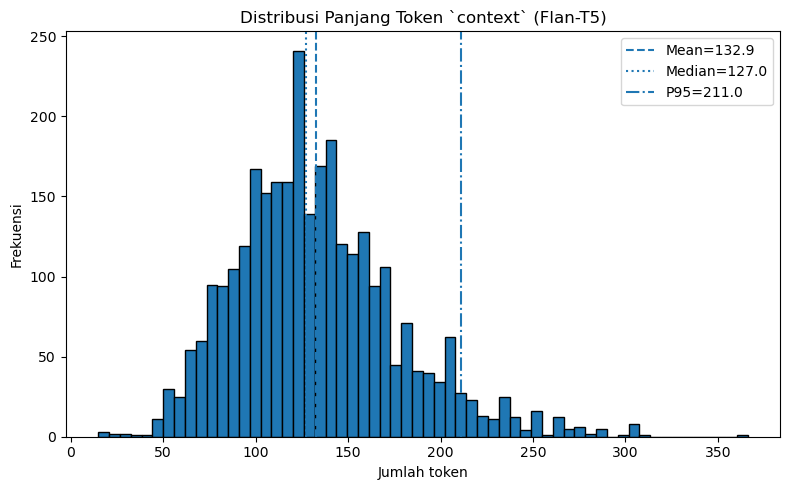

In [16]:
lengths = token_lengths_for_column(facqa_wo_dedupe, col="passage_text", batch_size=512)
stats = describe_lengths(lengths)
# 4) Cetak statistik
print("=== Statistik panjang token `context` (Flan-T5) ===")
for k in ["count","mean","std","min","p50_median","p90","p95","p99","max","> 256","> 512","> 600","> 1024"]:
    if k in stats:
        if k.startswith("> "):
            print(f"{k:>8}: {stats[k]:6.2f}%")
        elif k in {"mean","std","p50_median","p90","p95","p99"}:
            print(f"{k:>12}: {stats[k]:.2f}")
        else:
            print(f"{k:>12}: {stats[k]}")

# 5) Visualisasi histogram
plt.figure(figsize=(8,5))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Distribusi Panjang Token `context` (Flan-T5)")
plt.xlabel("Jumlah token"); plt.ylabel("Frekuensi")

# Garis bantu mean/median/p95
mean_v = np.mean(lengths) if lengths.size else 0
med_v  = np.median(lengths) if lengths.size else 0
p95_v  = np.percentile(lengths, 95) if lengths.size else 0
plt.axvline(mean_v, linestyle="--", label=f"Mean={mean_v:.1f}")
plt.axvline(med_v,  linestyle=":",  label=f"Median={med_v:.1f}")
plt.axvline(p95_v,  linestyle="-.", label=f"P95={p95_v:.1f}")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
facqa_wo_dedupe=facqa_wo_dedupe.remove_columns(['question', 'passage', 'seq_label'])
facqa_wo_dedupe=facqa_wo_dedupe.rename_column('answer_text', 'answer')

# mapping nama lama ke nama baru
rename_map = {
    "question_text": "question",
    "question_text_norm": "question_norm",
    "question_text_stem": "question_stem",
}

# rename kolom
facqa_wo_dedupe = facqa_wo_dedupe.rename_columns(rename_map)

In [20]:
facqa_wo_dedupe.save_to_disk("facqa_finish")

Saving the dataset (1/1 shards): 100%|██████████| 3001/3001 [00:00<00:00, 147956.54 examples/s]


# Isi negative passages

In [1]:
from datasets import load_dataset
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok")

c:\Users\LENOVO\anaconda3\envs\recomp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ambil hanya split train
corpus = corpus["train"]

# shuffle dengan seed biar hasil konsisten
corpus = corpus.shuffle(seed=42)

# pilih 300 ribu baris pertama setelah shuffle
corpus = corpus.select(range(300_000))

print(corpus)

Dataset({
    features: ['docid', 'title', 'text'],
    num_rows: 300000
})


In [4]:
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

model_name = "intfloat/multilingual-e5-small"
embedding_tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name).to("cuda:0")

# Fungsi average pooling
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

corpus_dict = {row["docid"]: (row["title"], row["text"]) for row in corpus}
corpus_docids = list(corpus_dict.keys())
corpus_texts = [f"passage: {corpus_dict[docid][0]} | {corpus_dict[docid][1]}" for docid in corpus_docids]

In [5]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import faiss
batch_size = 128  # Sesuaikan dengan VRAM yang tersedia
corpus_embeddings = []

for start_idx in tqdm(range(0, len(corpus_texts), batch_size), desc="Encoding Corpus"):
    end_idx = min(start_idx + batch_size, len(corpus_texts))
    batch_texts = corpus_texts[start_idx:end_idx]

    batch_dict = embedding_tokenizer(batch_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict = {k: v.to("cuda:0") for k, v in batch_dict.items()}

    with torch.no_grad():
        outputs = embedding_model(**batch_dict)

    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalisasi untuk cosine similarity
    corpus_embeddings.append(embeddings.to(torch.float32).cpu())  # Pastikan float32 dan tetap di CPU

Encoding Corpus: 100%|██████████| 2344/2344 [08:39<00:00,  4.51it/s]


In [33]:
import psutil
import numpy as np

def max_rows_fit(dim, dtype=np.float32, use_fraction=0.6):
    """Perkirakan maksimum baris embedding float yang aman ditampung di RAM."""
    avail = psutil.virtual_memory().available  # bytes RAM yang bebas
    bytes_per = np.dtype(dtype).itemsize * dim
    return int((avail * use_fraction) // bytes_per)

# contoh pakai dim dinamis dari satu batch kecil
import torch
dummy = corpus_embeddings[0] if len(corpus_embeddings) else None  # kalau kamu masih punya 1 batch tensor
if dummy is not None:
    dim = dummy.shape[1] if dummy.ndim == 2 else embedding_model.config.hidden_size
else:
    dim = embedding_model.config.hidden_size  # fallback

print("Perkiraan baris maksimal:", max_rows_fit(dim, np.float32, use_fraction=0.6))

Perkiraan baris maksimal: 503065


In [7]:
import numpy as np
# Gabungkan semua embedding menjadi satu tensor besar
corpus_embeddings = torch.cat(corpus_embeddings, dim=0).numpy().astype(np.float32)  # Konversi ke NumPy

# Buat FAISS index untuk pencarian similarity
index = faiss.IndexFlatIP(corpus_embeddings.shape[1])  # IP = Inner Product (Cosine Similarity)
index.add(corpus_embeddings)  # Tambahkan corpus embeddings ke FAISS

In [10]:
# Simpan index faiss
import os
os.makedirs("./generated_data", exist_ok=True)
faiss.write_index(index, "./generated_data/_corpus_faiss.idx")

In [18]:
import gc
import numpy as np
import torch
import torch.nn.functional as F

def add_negative_passages(batch, indices, question_col, dataset_name):
    """
    Tambahkan negative passages ke batch.
    - dataset_name in {"facqa","indoqa"}  -> ambil top-2 negatif.
    - dataset_name == "tydiqa"            -> aturan lama (2/1/0 tergantung #positives).
    - lainnya (fallback)                  -> aturan lama.
    """
    ds = (dataset_name or "").lower()

    # 1) Encode semua query dalam batch
    batch_queries = [f"query: {q}" for q in batch[question_col]]
    batch_dict = embedding_tokenizer(
        batch_queries, max_length=512, padding=True, truncation=True, return_tensors='pt'
    )
    batch_dict = {k: v.to("cuda:0") for k, v in batch_dict.items()}

    with torch.no_grad():
        outputs = embedding_model(**batch_dict)

    query_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    query_embeddings = F.normalize(query_embeddings, p=2, dim=1).cpu().numpy().astype(np.float32)  # (B, dim)

    # 2) FAISS search (ambil kandidat cukup banyak agar tidak habis setelah exclude positives)
    #    7 awalnya; kita buat sedikit lebih longgar.
    topk = 4
    D, I = index.search(query_embeddings, topk)

    # 3) Kumpulkan negatif per query
    negative_passages_batch = []
    for i, idx in enumerate(indices):
        
        if ds in {"facqa", "indoqa"}:
            max_negatives = 2
        else:  # "tydiqa" atau fallback
            positive_docids = set(p["docid"] for p in batch["positive_passages"][i])
            num_positive = len(positive_docids)
            if num_positive == 1:
                max_negatives = 2
            elif num_positive == 2:
                max_negatives = 1
            else:  # 3+
                max_negatives = 0

        selected_negative_passages = []
        if max_negatives > 0:
            for doc_idx in I[i]:
                docid = corpus_docids[doc_idx]
                if dataset_name=='tydiqa' and docid in positive_docids:
                    continue
                title, text = corpus_dict[docid]
                selected_negative_passages.append(
                    {"docid": docid, "title": title, "text": text}
                )
                if len(selected_negative_passages) == max_negatives:
                    break

        negative_passages_batch.append(selected_negative_passages)

    batch["mr_negative_passages"] = negative_passages_batch

    # 4) Bersihkan memori
    del batch_dict, outputs, query_embeddings
    torch.cuda.empty_cache()
    gc.collect()

    return batch

## FacQA 

In [ ]:
facqa_wo_dedupe = facqa_wo_dedupe.map(
    add_negative_passages, 
    with_indices=True, 
    batched=True, 
    batch_size=16, 
    fn_kwargs=
    {
        "question_col":"question", 
        "dataset_name":"facqa"
    } 
)

Map: 100%|██████████| 3001/3001 [01:38<00:00, 30.40 examples/s]


In [ ]:
facqa_wo_dedupe.save_to_disk("facqa_with_negs")

Saving the dataset (1/1 shards): 100%|██████████| 3001/3001 [00:00<00:00, 141437.70 examples/s]


## IndoQA

In [ ]:
indoqa = indoqa_clean
indoqa

Dataset({
    features: ['id', 'question', 'answer', 'passage_text', 'question_norm', 'question_stem'],
    num_rows: 4247
})

In [26]:
indoqa = indoqa.map(
    add_negative_passages, 
    with_indices=True, 
    batched=True, 
    batch_size=16, 
    fn_kwargs=
    {
        "question_col":"question", 
        "dataset_name":"indoqa"
    } 
)

Map: 100%|██████████| 4247/4247 [02:23<00:00, 29.56 examples/s]


In [29]:
indoqa.save_to_disk("./generated_data/indoqa_with_negs")

Saving the dataset (0/1 shards):   0%|          | 0/4247 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 4247/4247 [00:00<00:00, 139688.44 examples/s]


## TyDi

In [8]:
from datasets import load_from_disk
tydi = load_from_disk("tydi_finish")
tydi

Dataset({
    features: ['id', 'document_title', 'passage_text', 'query', 'question_norm', 'question_stem', 'answer', 'mr_query_id', 'mr_docid', 'mr_negative_passages'],
    num_rows: 5912
})

In [9]:
def passage_miss_answer(example):
    passage = example["passage_text"]
    answers = example["answer"] or []  # list of string
    
    # True kalau tidak ada satu pun jawaban yang muncul di passage_text
    return not any(ans in passage for ans in answers)

In [12]:
tydi_miss = tydi.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")
print(tydi_miss[0])

Jumlah baris yang miss: 3552
{'id': '2678620215944634419-0', 'document_title': 'Televisi di Indonesia', 'passage_text': 'Stasiun televisi yang dikelola negara, TVRI mengadakan monopoli televisi di Indonesia sampai tahun 1989, ketika stasiun komersial pertama, RCTI (Rajawali Citra Televisi Indonesia) memulai siarannya sebagai stasiun televisi lokal dan kemudian diberikan lisensi untuk mengudara secara nasional setahun kemudian.', 'query': 'Aapakah stasiun pertama di Indonesia?', 'question_norm': 'aapa stasiun pertama di indonesia?', 'question_stem': 'aapa stasiun pertama di indonesia', 'answer': ['tvri'], 'mr_query_id': '5433', 'mr_docid': '2335198#0', 'mr_negative_passages': [{'docid': '41276#0', 'text': 'TVRI Jogja adalah stasiun televisi regional milik Televisi Republik Indonesia yang merupakan stasiun daerah pertama di Indonesia, didirikan pada tahun 1965. Pertama berdiri di Yogyakarta berlokasi di Jl. Hayam Wuruk, tepatnya saat TVRI Jogja dipimpin oleh Kepala Stasiun yang pertama y

In [26]:
from datasets import load_from_disk

# tydi = load_from_disk("tydi_finish")

# filter yang kosong
tydi_empty = tydiqa_with_mr.filter(lambda x: not x["mr_negative_passages"] or len(x["mr_negative_passages"]) == 0)

# filter yang ada isinya
tydi_filled = tydiqa_with_mr.filter(lambda x: x["mr_negative_passages"] and len(x["mr_negative_passages"]) > 0)

print("Kosong:", len(tydi_empty))
print("Berisi:", len(tydi_filled))

Filter: 100%|██████████| 5912/5912 [00:01<00:00, 3311.93 examples/s]

Kosong: 1614
Berisi: 4298


In [45]:
mr_tydi = load_dataset("castorini/mr-tydi", "indonesian")
mr_tydi

DatasetDict({
    train: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 4902
    })
    dev: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 1224
    })
    test: Dataset({
        features: ['query_id', 'query', 'positive_passages', 'negative_passages'],
        num_rows: 829
    })
})

In [ ]:


# filter baris yang miss
tydi_miss = tydi_empty.filter(passage_miss_answer)

print(f"Jumlah baris yang miss: {len(tydi_miss)}")
print(tydi_miss[0])

Filter: 100%|██████████| 1614/1614 [00:00<00:00, 11634.71 examples/s]

Jumlah baris yang miss: 20
{'id': '3283543765806791008-1', 'document_title': 'Paritas (matematika)', 'passage_text': 'Definisi formal bilangan genap adalah adalah bilangan bulat dalam bentuk n=2k, dimana k adalah bilangan bulat; itu kemudian dapat dibuktikan bahwa bilangan ganjil adalah bilangan bulat dalam bentuk n=2k+1. Penggolongan ini hanya berlaku untuk bilangan bulat, dengan kata lain, bilangan tak bulat seperti 1/2, 4201, atau tak hingga bukan bilangan genap maupun ganjil.', 'question': 'Apakah bilangan genap?', 'question_norm': 'apa bilangan genap?', 'question_stem': 'apa bilang genap', 'answer': ['bilangan bulat dalam bentuk n=2<i data-parsoid=\'{"dsr":[2454.2459'], 'mr_query_id': '316', 'mr_docid': '1881645#1', 'mr_title': 'Paritas (matematika)', 'mr_text': 'Definisi formal bilangan genap adalah adalah bilangan bulat dalam bentuk n=2<i data-parsoid=\'{"dsr":[2454,2459,2,2]}\'>k, di mana k adalah bilangan bulat;[3] itu kemudian dapat dibuktikan bahwa bilangan ganjil adalah bil

In [28]:
from datasets import load_dataset

# load dataset gold
tydiqa_gold = load_dataset("khalidalt/tydiqa-goldp", "indonesian", trust_remote_code=True)

# ambil semua id dari tydi_miss
ids_miss = set(tydi_miss["id"])

# filter split train/dev/test dari tydiqa_gold
filtered_splits = {}
for split_name, ds in tydiqa_gold.items():
    ds_filtered = ds.filter(lambda x: x["id"] in ids_miss)
    filtered_splits[split_name] = ds_filtered
    print(f"{split_name}: {len(ds_filtered)} baris cocok")



Filter: 100%|██████████| 5702/5702 [00:00<00:00, 15507.30 examples/s]


train: 16 baris cocok


Filter: 100%|██████████| 565/565 [00:00<00:00, 9657.60 examples/s]

validation: 4 baris cocok


In [30]:
import pandas as pd

with pd.ExcelWriter("tydiqa_gold_matched.xlsx", engine="openpyxl") as writer:
    for split_name, ds in filtered_splits.items():
        df = ds.to_pandas()
        df.to_excel(writer, sheet_name=split_name, index=False)

print("File berhasil disimpan: tydiqa_gold_matched.xlsx")


File berhasil disimpan: tydiqa_gold_matched.xlsx


In [31]:
# kalau ingin gabungkan semua split jadi satu dataset
from datasets import concatenate_datasets
tydiqa_gold_matched = concatenate_datasets(list(filtered_splits.values()))

print(tydiqa_gold_matched)

Dataset({
    features: ['id', 'language', 'document_title', 'passage_text', 'question_text', 'answers'],
    num_rows: 20
})


In [ ]:
def passage_contains_all_answers(example):
    passage = example["passage_text"]
    # ambil list jawaban dari kolom answers.text
    answers = list(example["answers"]["text"])
    
    # True kalau semua jawaban ada di passage_text
    return all(ans in passage for ans in answers)

# filter baris yang tidak mengandung semua jawaban
missing_answers = tydiqa_gold_matched.filter(lambda x: not passage_contains_all_answers(x))

print(f"Total baris: {len(tydiqa_gold_matched)}")
print(f"Baris yang passage_text TIDAK mengandung semua jawaban: {len(missing_answers)}")


Filter: 100%|██████████| 20/20 [00:00<00:00, 623.82 examples/s]


Total baris: 20
Baris yang passage_text TIDAK mengandung semua jawaban: 0


IndexError: Invalid key: 0 is out of bounds for size 0

In [46]:
import pandas as pd

# konversi dataset ke DataFrame
df_miss = tydi_miss.to_pandas()

# simpan ke excel
output_path = "tydi_miss.xlsx"
df_miss.to_excel(output_path, index=False)

print(f"File berhasil disimpan ke {output_path} dengan {len(df_miss)} baris.")

File berhasil disimpan ke tydi_miss.xlsx dengan 943 baris.


In [20]:
from datasets import Features, Value, Sequence

# skema kolom baru
NEG_FEATURE = Sequence(feature={
    "docid": Value("string"),
    "title": Value("string"),
    "text": Value("string"),
})
NEW_COL_FEATURES = Features({
    "document_title": Value("string"),
    "mr_negative_passages": NEG_FEATURE,
})

def _str_or_empty(x):
    return "" if x is None else str(x)

def _norm_one_row(v):
    """
    Normalkan 1 baris mr_negative_passages menjadi list[dict{docid,title,text}] (semua string).
    """
    if v is None:
        return []
    if isinstance(v, list):
        out = []
        for d in v:
            if isinstance(d, dict):
                out.append({
                    "docid": _str_or_empty(d.get("docid")),
                    "title": _str_or_empty(d.get("title")),
                    "text":  _str_or_empty(d.get("text")),
                })
            elif isinstance(d, (list, tuple)):
                # (docid, title, text) atau variasi pendek
                did = _str_or_empty(d[0]) if len(d) > 0 else ""
                tit = _str_or_empty(d[1]) if len(d) > 1 else ""
                txt = _str_or_empty(d[2]) if len(d) > 2 else ""
                out.append({"docid": did, "title": tit, "text": txt})
            else:
                # string/angka/tipe lain -> jadikan text
                out.append({"docid": "", "title": "", "text": _str_or_empty(d)})
        return out
    # kalau bukan list → bungkus sebagai satu elemen text
    return [{"docid": "", "title": "", "text": _str_or_empty(v)}]

def _add_and_cast_cols(batch):
    n = len(batch[next(iter(batch))]) if batch else 0

    # document_title (string)
    if "document_title" in batch:
        doc_titles = [_str_or_empty(x) for x in batch["document_title"]]
    else:
        doc_titles = [""] * n

    # mr_negative_passages (list[dict])
    if "mr_negative_passages" in batch:
        neg_rows = [_norm_one_row(v) for v in batch["mr_negative_passages"]]
    else:
        neg_rows = [[] for _ in range(n)]

    return {
        "document_title": doc_titles,
        "mr_negative_passages": neg_rows,
    }

# Terapkan ke facqa & indoqa (tydi sudah lengkap)
facqa  = facqa.map(_add_and_cast_cols, batched=True, features=NEW_COL_FEATURES, desc="Ensure facqa titles+negs")
indoqa = indoqa.map(_add_and_cast_cols, batched=True, features=NEW_COL_FEATURES, desc="Ensure indoqa titles+negs")

# cek skema
print(facqa.features)
print(indoqa.features)


Ensure facqa titles+negs:   0%|          | 0/3001 [00:00<?, ? examples/s]


KeyError: 'id'

In [95]:
# Urutkan duplikat berdasarkan question_stem
dupes_sorted = dupes_df.sort_values(by="question_stem").reset_index(drop=True)

# Simpan ke Excel
dupes_sorted.to_excel("all_datasets_question_stem_duplicates.xlsx", index=False)

print("✅ File 'all_datasets_question_stem_duplicates.xlsx' berhasil dibuat.")


✅ File 'all_datasets_question_stem_duplicates.xlsx' berhasil dibuat.


In [4]:
from datasets import Dataset
import numpy as np

# 1) Drop baris dengan id tertentu
tydi_wrong_labels_index = [
    "7087322768323666798-2",
    "-1483127104798159762-2",
    "-954542885931683301-58",
    "-2854454553098103373-6",
]
BAD_ID_SET = set(tydi_wrong_labels_index)

before_n = len(all_ds)
all_ds = all_ds.filter(lambda _id: _id not in BAD_ID_SET, input_columns=["id"])
after_bad_drop = len(all_ds)
print(f"[Step 1] Removed by id list: {before_n - after_bad_drop} rows")

# 2) Dedup question_stem dengan preferensi source == "tydiqa_with_mr"
#    (pakai pandas untuk memudahkan sort berprioritas)
df = all_ds.to_pandas()

# simpan urutan asli agar deterministik
df["_orig_idx"] = np.arange(len(df), dtype=np.int64)

# rank: 0 untuk 'tydiqa_with_mr' (prioritas tertinggi), 1 untuk selain itu
df["_src_rank"] = (df["source"] != "tydiqa_with_mr").astype(int)

# sort per group lalu drop_duplicates per question_stem (keep yang rank paling kecil)
df_sorted = df.sort_values(["question_stem", "_src_rank", "_orig_idx"])
df_dedup  = df_sorted.drop_duplicates(subset=["question_stem"], keep="first")

# bersih-bersih kolom bantu
df_dedup = df_dedup.drop(columns=["_orig_idx", "_src_rank"])

# kembali ke HF Dataset
all_ds = Dataset.from_pandas(df_dedup, preserve_index=False)

print(f"[Step 2] After dedup by question_stem (prefer 'tydiqa_with_mr'): {len(all_ds)} rows")


[Step 1] Removed by id list: 4 rows
[Step 2] After dedup by question_stem (prefer 'tydiqa_with_mr'): 13146 rows


In [5]:
import re, unicodedata
from itertools import zip_longest

def _normalize_negatives(negs):
    """
    Normalisasi kolom mr_negative_passages agar tahan bentuk:
    - list of dict: [{'title':..., 'text':...}, ...]
    - list of tuple/list: [(title, text), ...] / [['t','x'], ...]
    - dict of lists: {'title': [...], 'text': [...]}
    - list of string: [text, ...]  (tanpa title)
    - string tunggal
    - None
    Return: list of dict atau None
    """
    if negs is None:
        return None

    out = []

    # dict of lists (HF kadang mem-flatten struct menjadi dict of lists saat batched)
    if isinstance(negs, dict) and ("title" in negs or "text" in negs):
        titles = negs.get("title", [])
        texts  = negs.get("text", [])
        for ti, tx in zip_longest(titles, texts, fillvalue=None):
            ti2 = normalize(ti, lowercase=False) if ti is not None else None
            tx2 = normalize(tx, lowercase=False) if tx is not None else None
            out.append({"title": ti2, "text": tx2})
        return out

    # list varian
    if isinstance(negs, list):
        for d in negs:
            if isinstance(d, dict):
                ti = d.get("title")
                tx = d.get("text")
                ti2 = normalize(ti, lowercase=False) if ti is not None else None
                tx2 = normalize(tx, lowercase=False) if tx is not None else None
                out.append({"title": ti2, "text": tx2})
            elif isinstance(d, (tuple, list)):
                # asumsi (title, text) atau (text_only,) dsb.
                if len(d) >= 2:
                    ti, tx = d[0], d[1]
                    ti2 = normalize(ti, lowercase=False) if ti is not None else None
                    tx2 = normalize(tx, lowercase=False) if tx is not None else None
                    out.append({"title": ti2, "text": tx2})
                elif len(d) == 1:
                    tx = d[0]
                    tx2 = normalize(tx, lowercase=False) if tx is not None else None
                    out.append({"title": None, "text": tx2})
            elif isinstance(d, str):
                out.append({"title": None, "text": normalize(d, lowercase=False)})
            else:
                # tipe tak dikenal -> lewatkan apa adanya sebagai text
                out.append({"title": None, "text": normalize(str(d), lowercase=False)})
        return out

    # string tunggal
    if isinstance(negs, str):
        return [{"title": None, "text": normalize(negs, lowercase=False)}]

    # fallback: jadikan string lalu simpan sebagai text
    return [{"title": None, "text": normalize(str(negs), lowercase=False)}]

def normalize_fields(batch):
    answers = batch["answer"]
    passages = batch.get("passage_text", [])
    titles   = batch.get("document_title", [])
    negs    = batch.get("mr_negative_passages", [])

    new_answers, new_passages, new_titles, new_neg_passages = [], [], [], []

    n = len(answers)
    for i in range(n):
        # answers: list[str]
        ans_list = answers[i] or []
        normed_ans = [normalize(a, lowercase=False) for a in ans_list if a is not None]
        new_answers.append(normed_ans)

        # passage_text
        passage = passages[i] if i < len(passages) else None
        new_passages.append(normalize(passage, lowercase=False) if passage else passage)

        # document_title
        doc_title = titles[i] if i < len(titles) else None
        new_titles.append(normalize(doc_title, lowercase=False) if doc_title else doc_title)

        # mr_negative_passages (ragam bentuk)
        neg_item = negs[i] if i < len(negs) else None
        new_neg_passages.append(_normalize_negatives(neg_item))

    return {
        "answer": new_answers,
        "passage_text": new_passages,
        "document_title": new_titles,
        "mr_negative_passages": new_neg_passages,
    }

# Terapkan ke dataset
all_ds = all_ds.map(
    normalize_fields,
    batched=True,
    batch_size=100,
    load_from_cache_file=False,
    desc="Normalize answers/passages/titles/negatives"
)


Normalize answers/passages/titles/negatives: 100%|██████████| 13146/13146 [00:11<00:00, 1146.06 examples/s]


# Isi negatives dari dev dan test dengan passages dari corpus

In [35]:
corpus = load_dataset("khalidrizki/indonesian-wiki-chunked-180tok", trust_remote_code=True)
corpus

DatasetDict({
    train: Dataset({
        features: ['docid', 'title', 'text'],
        num_rows: 1588236
    })
})

ambil negative passages buat yg belum punya

In [64]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch import Tensor
import gc

# ===== Model & tokenizer (Multilingual-E5-Small) =====
model_name = "intfloat/multilingual-e5-small"
embedding_tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
embedding_model = embedding_model.to(device)

# ===== Helper: average pooling =====
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    masked = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return masked.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# ===== Top-K selector over mr_negative_passages using query_norm =====
TOP_K = 4  # ganti ke 2 jika hanya ingin top-2

def select_topk_mr_negative_passages(example):
    negs = example.get("mr_negative_passages") or []
    # Jika kosong atau sudah <= TOP_K, tidak perlu proses
    if len(negs) <= TOP_K:
        return example

    # E5 expects prefixes: 'query: ...' dan 'passage: ...'
    query_text = f'query: {example.get("query_norm", "")}'

    # Rakit teks passage: "passage: {title} | {text}"
    neg_texts = []
    for neg in negs:
        title = (neg.get("title") or "").strip()
        text  = (neg.get("text")  or "").strip()
        neg_texts.append(f'passage: {title} | {text}')

    # Tokenisasi gabungan (query + semua negative passages)
    batch_dict = embedding_tokenizer(
        [query_text] + neg_texts,
        max_length=512,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

    with torch.no_grad():
        outputs = embedding_model(**batch_dict)

    # Embedding + normalisasi (cosine)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)

    # Pisah query vs passages
    query_emb = embeddings[0].unsqueeze(0)
    neg_embs  = embeddings[1:]

    # Similarity (cosine) → ambil TOP_K indeks terbaik
    scores = (query_emb @ neg_embs.T).squeeze(0)
    top_idx = torch.argsort(scores, descending=True)[:TOP_K].tolist()

    # Pertahankan hanya TOP_K dokumen terbaik
    example["mr_negative_passages"] = [negs[i] for i in top_idx]

    # Bersih-bersih memori
    del batch_dict, outputs, embeddings, scores, query_emb, neg_embs
    torch.cuda.empty_cache() if device.startswith("cuda") else None
    gc.collect()

    return example

# ===== Terapkan ke dataset =====
# (single-process aman untuk fungsi berat GPU seperti ini)
tydiqa_with_mr_neg_filled = tydiqa_with_mr_neg_filled.map(
    select_topk_mr_negative_passages,
    batched=False,
    load_from_cache_file=False,
)

Map: 100%|██████████| 4298/4298 [38:27<00:00,  1.86 examples/s]


Chunking negative passages yang sudah diatur oleh Mr. TyDi

ambil top 2 dokumen negatif utk split train

truncate?